In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
import random
from sklearn.model_selection import train_test_split
path="/its/home/drs25/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
print(f"Using device: {device}")
csfont = {'fontname':'Times New Roman'}
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

Using device: cuda


## Data set import

In [2]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

### gen data

In [3]:
def genData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    """data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data.X=np.concatenate([data.X,data2.X])
    data.y=np.concatenate([data.y,data2.y])
    del data2
    data3=loaded(to,filename="X_data_newMorph.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data3.X])
    data.y=np.concatenate([data.y,data3.y])
    del data3"""
    #data.resize(percentage)
    #data.augment()
    data.shuffle()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_data_newMorph.npz")
    #d.applySobel()
    #p20=d.X[np.where(d.y==3)]
    #data.X=np.concatenate([data.X,p20])
    #data.y=np.concatenate([data.y,np.zeros((len(p20)))+11])
    #data.resize(percentage)
    print("LOADED DATASET...")
    #data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to)*data.X.shape[2],data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader

def genDataANN(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    data.shuffle()
    data.resize(percentage)
    print("LOADED DATASET...")
    data.augment()
    n=int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to)*data.X.shape[2]*data.X.shape[3]))
    del data
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    del x_data
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    
    return train_loader,test_loader
def gen3DData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    data.resize(percentage)
    n=int(len(data.X)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique
def genLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    #data.applySobel()
    #data=loaded(to,filename="X_data_15.npz")
    data.applySobel()
    #data3=loaded(to,filename="X_data_gel_15.npz")
    #data3.applySobel()
    #data.X=np.concatenate([data.X,data2.X,data3.X])
    #data.y=np.concatenate([data.y,data2.y,data3.y])
    #del data2
    #del data3
    data.augment()
    #add lowest unseen 
    #d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
    #d.applySobel()
    #data.augment()
    data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),abs(frm-to),data.X.shape[2]*data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader
def genCNNLSTMData(frm,to,percentage=1):
    torch.cuda.empty_cache()
    data=loaded(to,filename="X_data_newMorph.npz")
    data.applySobel()
    data2=loaded(to,filename="X_data_15.npz")
    data2.applySobel()
    data3=loaded(to,filename="X_data_gel_15.npz")
    data3.applySobel()
    data.X=np.concatenate([data.X,data2.X,data3.X])
    data.y=np.concatenate([data.y,data2.y,data3.y])
    del data2
    del data3
    data.augment()

    #data.resize(percentage)
    n=-1#int(len(data.X)*0.7)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.y[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.X[0:n].reshape((len(data.X[0:n]),1,abs(frm-to),data.X.shape[2],data.X.shape[3]))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.y[0:n][i]
    return train_loader,test_loader,unique

## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width,output=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.flatten_size = 10 * (input_height // 4) * (input_width // 4)
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class SimpleANN(nn.Module):
    def __init__(self,input, hidden,output=15):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, output)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x=self.fc3(x)
        return x
    
class Simple3DCNN(nn.Module):
    def __init__(self, input_depth, input_height, input_width):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(32, 10, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        
        depth = input_depth
        height = input_height
        width = input_width
        
        depth = depth // 2  # after first pooling
        height = height // 2
        width = width // 2
        
        depth = depth // 2  # after second pooling
        height = height // 2
        width = width // 2
        
        # Number of output features from conv layers (channels * depth * height * width)
        self.flatten_size = 10 * depth * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 13)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class CNN_LSTM(nn.Module):
    def __init__(self, input_width, input_height, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )
        
        # Calculate the CNN output size
        cnn_output_size = self._get_cnn_output_size(input_width, input_height)
        
        # Define the LSTM part
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the final fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def _get_cnn_output_size(self, width, height):
        # Create a dummy tensor with the given width and height
        dummy_input = torch.zeros(1, 1, height, width)
        
        # Pass the dummy tensor through the CNN
        dummy_output = self.cnn(dummy_input)
        
        # Calculate the output size by flattening the output
        return dummy_output.view(-1).size(0)
    
    def forward(self, x):
        batch_size, c, sequence_length, h, w = x.size()
        # Reshape input to (batch_size * sequence_length, c, h, w) for CNN
        c_in = x.view(batch_size * sequence_length, c, h, w)
        
        # Pass through CNN
        c_out = self.cnn(c_in)
        
        # Flatten the CNN output
        c_out = c_out.view(c_out.size(0), -1)
        
        # Reshape to (batch_size, sequence_length, cnn_output_size) for LSTM
        lstm_in = c_out.view(batch_size, sequence_length, -1)
        
        # Pass through LSTM
        lstm_out, (h_n, c_n) = self.lstm(lstm_in)
        
        # Get the output from the last time step
        output = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        output = self.fc(output)
        
        return output
    


## Train

In [5]:
def run(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleCNN(image.shape[0],image.shape[1],output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def runANN(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0]
    output=len(next(iter(train_loader))[1][0])
    print("SHAPE....",image.shape)
    model = SimpleANN(image.shape[0],400,output=output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

def run3D(train_loader,frm,to):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    model = Simple3DCNN(image.shape[0],image.shape[1],image.shape[2]).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed
def runLSTM(train_loader,frm,to,num_epochs = 100):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = SimpleLSTM(image.shape[0],350,output,3).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history
def runLSTMcnn(train_loader,frm,to,num_epochs=150):
    train_history=[]
    image=next(iter(train_loader))
    image=image[0][0][0][0]
    output=len(next(iter(train_loader))[1][0])
    model = CNN_LSTM(image.shape[1],image.shape[0],1000,1,output).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            #print(inputs.shape,outputs.shape,labels.shape)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        train_history.append(loss.cpu().detach().numpy())
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model,train_history

### ANN train

In [15]:
torch.cuda.empty_cache()
train_loader,test_loader=genDataANN(0,4)

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.48 GB
torch.Size([6300, 52800])
torch.Size([6300, 15])


/tmp/ipykernel_1576422/702361806.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


In [16]:
model,history=runANN(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelANN") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelANN")

SHAPE.... torch.Size([52800])
Epoch [1/100], Step [126/126], Loss: 324.9312
Epoch [11/100], Step [126/126], Loss: 48.6270
Epoch [21/100], Step [126/126], Loss: 10.9573
Epoch [31/100], Step [126/126], Loss: 4.1670
Epoch [41/100], Step [126/126], Loss: 2.2464
Epoch [51/100], Step [126/126], Loss: 1.4630
Epoch [61/100], Step [126/126], Loss: 1.0482
Epoch [71/100], Step [126/126], Loss: 0.8039
Epoch [81/100], Step [126/126], Loss: 0.6449
Epoch [91/100], Step [126/126], Loss: 0.5333
Finished Training
Accuracy: 99.9920641218951 %
0.999920641218951
Accuracy: 99.99801591238268 %
0.9999801591238269


### CNN train

In [ ]:
torch.cuda.empty_cache()
train_loader,test_loader=genData(0,4)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodel_newMorph") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

: 

In [ ]:
plt.plot(history)
plt.grid(True)
plt.title("Loss of CNN on both datasets",fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+"/images/loss_of_uber_model.pdf")
plt.show()

: 

In [ ]:
train_loader,test_loader,unique=genData(0,4)
data=loaded(4,filename="X_data_newMorph.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=13).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()

: 

In [ ]:


ar=[]
acc=[]
for i in range(5):
    try:
        torch.cuda.empty_cache()
        train_loader,test_loader,unique=genData(0,4)
        model,history=run(train_loader,0,4)
        ar.append(history)
        print(calc(model,test_loader))
        print(calc(model,train_loader))
        acc.append(calc(model,test_loader))
        if acc[-1]>=max(acc):
            torch.save(model.state_dict(), path+"/model/mymmodel_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
    except MemoryError as e:
        try:
            del train_loader
            del test_loader
            del model
        except: 
            pass
ar=np.array(ar)
acc=np.array(acc)


np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/accuracies_of_NM_uber",acc)
np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/loss_of_NM_uber",ar)

: 

In [ ]:
#T EXPERIEMTN

ar_=[]
acc_=[]
for j in range(1,20,2):
    clear_output(wait=True)
    print("t SIZE:",j)
    ar=[]
    acc=[]
    for i in range(3):
        try:
            torch.cuda.empty_cache()
            train_loader,test_loader,unique=genLSTMData(0,j)
            model,history=runLSTM(train_loader,0,j)
            ar.append(history)
            print(calc(model,test_loader))
            print(calc(model,train_loader))
            acc.append(calc(model,test_loader))
            if acc[-1]>=max(acc):
                torch.save(model.state_dict(), path+"/models/lstm_") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
            del train_loader
            del test_loader
            del model
        except MemoryError as e:
            try:
                del train_loader
                del test_loader
                del model
            except: 
                pass
    ar=np.array(ar)
    acc=np.array(acc)
    ar_.append(ar)
    acc_.append(acc)
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMaccuracies_of_NM",np.array(acc_))
    np.save("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/LSTMloss_of_NM",np.array(ar_))

: 

In [ ]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores_NM_",test_scores)
        np.save(path+"saves/train_scores_NM",train_scores)




: 

#### resolution

In [12]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.zeros((len(resolutions),3))#np.load(path+"/data/test_resolutions_new.npy")#np.load(path+"/data/test_resolutions_uber.npy")#np.zeros((len(resolutions),3))
scores_train=np.zeros((len(resolutions),3))#np.load(path+"/data/train_resolutions_new.npy")#np.load(path+"/data/train_resolutions_uber.npy")#np.zeros((len(resolutions),3))
#ind=resolutions.index(0.7)
ind=0
try:
    for i, res in enumerate((resolutions[ind:])): #
        i+=ind
        print("Testing resolution",res)
        for j in range(3): #three trials on each
            torch.cuda.empty_cache()
            train_loader,test_loader=genData(0,4,res)
            model,history=run(train_loader,0,4,num_epochs = 130)
            test_acc=calc(model,test_loader)
            train_acc=calc(model,train_loader)
            #look at other stuff
            del train_loader
            del test_loader
            torch.cuda.empty_cache()
            #scores_test_NM[i][j]=len(a[a==0])/len(preds)
            scores_test[i][j]=test_acc
            scores_train[i][j]=train_acc
            print("\t\t",test_acc*100,"%",train_acc*100,"%")
            del model
except Exception as e:
    print(e)
    print(res)
np.save(path+"/data/test_resolutions",scores_test)
np.save(path+"/data/train_resolutions",scores_train)


Testing resolution 0.05
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5790
Epoch [11/130], Step [42/42], Loss: 60.1635
Epoch [21/130], Step [42/42], Loss: 25.3816
Epoch [31/130], Step [42/42], Loss: 10.0815
Epoch [41/130], Step [42/42], Loss: 5.6334
Epoch [51/130], Step [42/42], Loss: 2.7364
Epoch [61/130], Step [42/42], Loss: 1.7077
Epoch [71/130], Step [42/42], Loss: 0.3106
Epoch [81/130], Step [42/42], Loss: 0.2766
Epoch [91/130], Step [42/42], Loss: 0.1359
Epoch [101/130], Step [42/42], Loss: 0.1033
Epoch [111/130], Step [42/42], Loss: 0.0824
Epoch [121/130], Step [42/42], Loss: 0.0678
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5771
Epoch [11/130], Step [42/42], Loss: 61.1985
Epoch [21/130], Step [42/42], Loss: 22.2367
Epoch [31/130], Step [42/42], Loss: 7.8155
Epoch [41/130], Step [42/42], Loss: 4.3014
Epoch [51/130], Step [42/42], Loss: 1.8297
Epoch [61/130], Step [42/42], Loss: 0.3607
Epoch [71/130], Step [42/42], Loss: 0.2202
Epoch [81/130], Step [42/42], Loss: 0.1490
Epoch [91/130], Step [42/42], Loss: 0.1099
Epoch [101/130], Step [42/42], Loss: 0.0883
Epoch [111/130], Step [42/42], Loss: 0.0715
Epoch [121/130], Step [42/42], Loss: 0.0595
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7373
Epoch [11/130], Step [42/42], Loss: 72.0560
Epoch [21/130], Step [42/42], Loss: 29.3144
Epoch [31/130], Step [42/42], Loss: 10.0896
Epoch [41/130], Step [42/42], Loss: 5.0384
Epoch [51/130], Step [42/42], Loss: 2.6854
Epoch [61/130], Step [42/42], Loss: 0.8717
Epoch [71/130], Step [42/42], Loss: 0.3271
Epoch [81/130], Step [42/42], Loss: 0.1773
Epoch [91/130], Step [42/42], Loss: 0.1358
Epoch [101/130], Step [42/42], Loss: 0.1007
Epoch [111/130], Step [42/42], Loss: 0.0837
Epoch [121/130], Step [42/42], Loss: 0.0689
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5286
Epoch [11/130], Step [42/42], Loss: 59.9278
Epoch [21/130], Step [42/42], Loss: 29.6156
Epoch [31/130], Step [42/42], Loss: 13.3123
Epoch [41/130], Step [42/42], Loss: 6.6611
Epoch [51/130], Step [42/42], Loss: 3.9708
Epoch [61/130], Step [42/42], Loss: 2.0600
Epoch [71/130], Step [42/42], Loss: 0.5482
Epoch [81/130], Step [42/42], Loss: 0.2198
Epoch [91/130], Step [42/42], Loss: 0.1491
Epoch [101/130], Step [42/42], Loss: 0.1151
Epoch [111/130], Step [42/42], Loss: 0.0879
Epoch [121/130], Step [42/42], Loss: 0.0719
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7223
Epoch [11/130], Step [42/42], Loss: 74.0576
Epoch [21/130], Step [42/42], Loss: 37.0990
Epoch [31/130], Step [42/42], Loss: 12.7083
Epoch [41/130], Step [42/42], Loss: 5.2807
Epoch [51/130], Step [42/42], Loss: 2.2004
Epoch [61/130], Step [42/42], Loss: 0.7388
Epoch [71/130], Step [42/42], Loss: 0.3555
Epoch [81/130], Step [42/42], Loss: 0.1791
Epoch [91/130], Step [42/42], Loss: 0.1341
Epoch [101/130], Step [42/42], Loss: 0.1008
Epoch [111/130], Step [42/42], Loss: 0.0818
Epoch [121/130], Step [42/42], Loss: 0.0680
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6836
Epoch [11/130], Step [42/42], Loss: 98.6340
Epoch [21/130], Step [42/42], Loss: 40.2520
Epoch [31/130], Step [42/42], Loss: 14.6865
Epoch [41/130], Step [42/42], Loss: 6.2911
Epoch [51/130], Step [42/42], Loss: 3.1243
Epoch [61/130], Step [42/42], Loss: 1.4003
Epoch [71/130], Step [42/42], Loss: 0.4346
Epoch [81/130], Step [42/42], Loss: 0.2080
Epoch [91/130], Step [42/42], Loss: 0.1461
Epoch [101/130], Step [42/42], Loss: 0.1098
Epoch [111/130], Step [42/42], Loss: 0.0874
Epoch [121/130], Step [42/42], Loss: 0.0728
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.15
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7697
Epoch [11/130], Step [42/42], Loss: 95.8836
Epoch [21/130], Step [42/42], Loss: 37.9696
Epoch [31/130], Step [42/42], Loss: 14.2510
Epoch [41/130], Step [42/42], Loss: 7.4136
Epoch [51/130], Step [42/42], Loss: 4.4372
Epoch [61/130], Step [42/42], Loss: 2.2599
Epoch [71/130], Step [42/42], Loss: 0.7340
Epoch [81/130], Step [42/42], Loss: 0.2394
Epoch [91/130], Step [42/42], Loss: 0.1542
Epoch [101/130], Step [42/42], Loss: 0.1188
Epoch [111/130], Step [42/42], Loss: 0.0933
Epoch [121/130], Step [42/42], Loss: 0.0742
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6820
Epoch [11/130], Step [42/42], Loss: 60.5552
Epoch [21/130], Step [42/42], Loss: 26.1999
Epoch [31/130], Step [42/42], Loss: 9.6557
Epoch [41/130], Step [42/42], Loss: 4.9915
Epoch [51/130], Step [42/42], Loss: 2.3354
Epoch [61/130], Step [42/42], Loss: 1.1504
Epoch [71/130], Step [42/42], Loss: 0.2815
Epoch [81/130], Step [42/42], Loss: 0.1731
Epoch [91/130], Step [42/42], Loss: 0.1273
Epoch [101/130], Step [42/42], Loss: 0.0998
Epoch [111/130], Step [42/42], Loss: 0.0812
Epoch [121/130], Step [42/42], Loss: 0.0675
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6541
Epoch [11/130], Step [42/42], Loss: 58.8391
Epoch [21/130], Step [42/42], Loss: 24.7552
Epoch [31/130], Step [42/42], Loss: 10.2177
Epoch [41/130], Step [42/42], Loss: 5.7287
Epoch [51/130], Step [42/42], Loss: 3.3381
Epoch [61/130], Step [42/42], Loss: 1.6493
Epoch [71/130], Step [42/42], Loss: 0.6891
Epoch [81/130], Step [42/42], Loss: 0.2518
Epoch [91/130], Step [42/42], Loss: 0.1426
Epoch [101/130], Step [42/42], Loss: 0.1030
Epoch [111/130], Step [42/42], Loss: 0.0845
Epoch [121/130], Step [42/42], Loss: 0.0679
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.2
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.4720
Epoch [11/130], Step [42/42], Loss: 51.1414
Epoch [21/130], Step [42/42], Loss: 19.8879
Epoch [31/130], Step [42/42], Loss: 8.1780
Epoch [41/130], Step [42/42], Loss: 4.4246
Epoch [51/130], Step [42/42], Loss: 2.2916
Epoch [61/130], Step [42/42], Loss: 0.9095
Epoch [71/130], Step [42/42], Loss: 0.2739
Epoch [81/130], Step [42/42], Loss: 0.1641
Epoch [91/130], Step [42/42], Loss: 0.1197
Epoch [101/130], Step [42/42], Loss: 0.0957
Epoch [111/130], Step [42/42], Loss: 0.0770
Epoch [121/130], Step [42/42], Loss: 0.0641
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7390
Epoch [11/130], Step [42/42], Loss: 72.1890
Epoch [21/130], Step [42/42], Loss: 34.2028
Epoch [31/130], Step [42/42], Loss: 13.1264
Epoch [41/130], Step [42/42], Loss: 6.3399
Epoch [51/130], Step [42/42], Loss: 3.7823
Epoch [61/130], Step [42/42], Loss: 1.6982
Epoch [71/130], Step [42/42], Loss: 0.5427
Epoch [81/130], Step [42/42], Loss: 0.3341
Epoch [91/130], Step [42/42], Loss: 0.1472
Epoch [101/130], Step [42/42], Loss: 0.1098
Epoch [111/130], Step [42/42], Loss: 0.0886
Epoch [121/130], Step [42/42], Loss: 0.0748
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6779
Epoch [11/130], Step [42/42], Loss: 81.5126
Epoch [21/130], Step [42/42], Loss: 36.7150
Epoch [31/130], Step [42/42], Loss: 13.2512
Epoch [41/130], Step [42/42], Loss: 6.2410
Epoch [51/130], Step [42/42], Loss: 3.6679
Epoch [61/130], Step [42/42], Loss: 1.6601
Epoch [71/130], Step [42/42], Loss: 0.4589
Epoch [81/130], Step [42/42], Loss: 0.2081
Epoch [91/130], Step [42/42], Loss: 0.1371
Epoch [101/130], Step [42/42], Loss: 0.1043
Epoch [111/130], Step [42/42], Loss: 0.0857
Epoch [121/130], Step [42/42], Loss: 0.0659
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.25
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7874
Epoch [11/130], Step [42/42], Loss: 79.7904
Epoch [21/130], Step [42/42], Loss: 35.6249
Epoch [31/130], Step [42/42], Loss: 12.5157
Epoch [41/130], Step [42/42], Loss: 5.9700
Epoch [51/130], Step [42/42], Loss: 3.1618
Epoch [61/130], Step [42/42], Loss: 1.8101
Epoch [71/130], Step [42/42], Loss: 0.5644
Epoch [81/130], Step [42/42], Loss: 0.2001
Epoch [91/130], Step [42/42], Loss: 0.1536
Epoch [101/130], Step [42/42], Loss: 0.1081
Epoch [111/130], Step [42/42], Loss: 0.0847
Epoch [121/130], Step [42/42], Loss: 0.0730
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6798
Epoch [11/130], Step [42/42], Loss: 66.4352
Epoch [21/130], Step [42/42], Loss: 31.3288
Epoch [31/130], Step [42/42], Loss: 11.9715
Epoch [41/130], Step [42/42], Loss: 5.6410
Epoch [51/130], Step [42/42], Loss: 3.3140
Epoch [61/130], Step [42/42], Loss: 0.8202
Epoch [71/130], Step [42/42], Loss: 0.6317
Epoch [81/130], Step [42/42], Loss: 0.1956
Epoch [91/130], Step [42/42], Loss: 0.1412
Epoch [101/130], Step [42/42], Loss: 0.1018
Epoch [111/130], Step [42/42], Loss: 0.0796
Epoch [121/130], Step [42/42], Loss: 0.0669
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6767
Epoch [11/130], Step [42/42], Loss: 55.8014
Epoch [21/130], Step [42/42], Loss: 23.0053
Epoch [31/130], Step [42/42], Loss: 9.1502
Epoch [41/130], Step [42/42], Loss: 5.9328
Epoch [51/130], Step [42/42], Loss: 2.9903
Epoch [61/130], Step [42/42], Loss: 1.1212
Epoch [71/130], Step [42/42], Loss: 0.3307
Epoch [81/130], Step [42/42], Loss: 0.1882
Epoch [91/130], Step [42/42], Loss: 0.1283
Epoch [101/130], Step [42/42], Loss: 0.0993
Epoch [111/130], Step [42/42], Loss: 0.0793
Epoch [121/130], Step [42/42], Loss: 0.0688
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.3
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6231
Epoch [11/130], Step [42/42], Loss: 62.8673
Epoch [21/130], Step [42/42], Loss: 27.4477
Epoch [31/130], Step [42/42], Loss: 9.4294
Epoch [41/130], Step [42/42], Loss: 4.3033
Epoch [51/130], Step [42/42], Loss: 2.1441
Epoch [61/130], Step [42/42], Loss: 0.8409
Epoch [71/130], Step [42/42], Loss: 0.2686
Epoch [81/130], Step [42/42], Loss: 0.3152
Epoch [91/130], Step [42/42], Loss: 0.1288
Epoch [101/130], Step [42/42], Loss: 0.1049
Epoch [111/130], Step [42/42], Loss: 0.0825
Epoch [121/130], Step [42/42], Loss: 0.0676
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6838
Epoch [11/130], Step [42/42], Loss: 66.3630
Epoch [21/130], Step [42/42], Loss: 26.4230
Epoch [31/130], Step [42/42], Loss: 9.8091
Epoch [41/130], Step [42/42], Loss: 4.8964
Epoch [51/130], Step [42/42], Loss: 2.5833
Epoch [61/130], Step [42/42], Loss: 0.9646
Epoch [71/130], Step [42/42], Loss: 0.3111
Epoch [81/130], Step [42/42], Loss: 0.1856
Epoch [91/130], Step [42/42], Loss: 0.1372
Epoch [101/130], Step [42/42], Loss: 0.1021
Epoch [111/130], Step [42/42], Loss: 0.0822
Epoch [121/130], Step [42/42], Loss: 0.0681
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6407
Epoch [11/130], Step [42/42], Loss: 65.9807
Epoch [21/130], Step [42/42], Loss: 29.3374
Epoch [31/130], Step [42/42], Loss: 11.0224
Epoch [41/130], Step [42/42], Loss: 5.2364
Epoch [51/130], Step [42/42], Loss: 3.1584
Epoch [61/130], Step [42/42], Loss: 0.9704
Epoch [71/130], Step [42/42], Loss: 0.3021
Epoch [81/130], Step [42/42], Loss: 0.1953
Epoch [91/130], Step [42/42], Loss: 0.1356
Epoch [101/130], Step [42/42], Loss: 0.1055
Epoch [111/130], Step [42/42], Loss: 0.0827
Epoch [121/130], Step [42/42], Loss: 0.0703
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.35
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5434
Epoch [11/130], Step [42/42], Loss: 53.6419
Epoch [21/130], Step [42/42], Loss: 21.3890
Epoch [31/130], Step [42/42], Loss: 8.9669
Epoch [41/130], Step [42/42], Loss: 4.4029
Epoch [51/130], Step [42/42], Loss: 2.0595
Epoch [61/130], Step [42/42], Loss: 0.7016
Epoch [71/130], Step [42/42], Loss: 0.2444
Epoch [81/130], Step [42/42], Loss: 0.1579
Epoch [91/130], Step [42/42], Loss: 0.1172
Epoch [101/130], Step [42/42], Loss: 0.0936
Epoch [111/130], Step [42/42], Loss: 0.0743
Epoch [121/130], Step [42/42], Loss: 0.0628
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5835
Epoch [11/130], Step [42/42], Loss: 55.2346
Epoch [21/130], Step [42/42], Loss: 19.4154
Epoch [31/130], Step [42/42], Loss: 8.0422
Epoch [41/130], Step [42/42], Loss: 4.5779
Epoch [51/130], Step [42/42], Loss: 3.0728
Epoch [61/130], Step [42/42], Loss: 1.5162
Epoch [71/130], Step [42/42], Loss: 0.2980
Epoch [81/130], Step [42/42], Loss: 0.1686
Epoch [91/130], Step [42/42], Loss: 0.1178
Epoch [101/130], Step [42/42], Loss: 0.0913
Epoch [111/130], Step [42/42], Loss: 0.0761
Epoch [121/130], Step [42/42], Loss: 0.0628
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6404
Epoch [11/130], Step [42/42], Loss: 62.7771
Epoch [21/130], Step [42/42], Loss: 30.1678
Epoch [31/130], Step [42/42], Loss: 11.8183
Epoch [41/130], Step [42/42], Loss: 5.8983
Epoch [51/130], Step [42/42], Loss: 3.2783
Epoch [61/130], Step [42/42], Loss: 0.8194
Epoch [71/130], Step [42/42], Loss: 0.5848
Epoch [81/130], Step [42/42], Loss: 0.2011
Epoch [91/130], Step [42/42], Loss: 0.1344
Epoch [101/130], Step [42/42], Loss: 0.1104
Epoch [111/130], Step [42/42], Loss: 0.0848
Epoch [121/130], Step [42/42], Loss: 0.0715
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.4
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6784
Epoch [11/130], Step [42/42], Loss: 68.7537
Epoch [21/130], Step [42/42], Loss: 33.6894
Epoch [31/130], Step [42/42], Loss: 13.4924
Epoch [41/130], Step [42/42], Loss: 6.6743
Epoch [51/130], Step [42/42], Loss: 3.5839
Epoch [61/130], Step [42/42], Loss: 1.0203
Epoch [71/130], Step [42/42], Loss: 0.5066
Epoch [81/130], Step [42/42], Loss: 0.2092
Epoch [91/130], Step [42/42], Loss: 0.1442
Epoch [101/130], Step [42/42], Loss: 0.1140
Epoch [111/130], Step [42/42], Loss: 0.0912
Epoch [121/130], Step [42/42], Loss: 0.0735
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6773
Epoch [11/130], Step [42/42], Loss: 58.1843
Epoch [21/130], Step [42/42], Loss: 23.9242
Epoch [31/130], Step [42/42], Loss: 10.7515
Epoch [41/130], Step [42/42], Loss: 5.5980
Epoch [51/130], Step [42/42], Loss: 3.4439
Epoch [61/130], Step [42/42], Loss: 1.3880
Epoch [71/130], Step [42/42], Loss: 0.5131
Epoch [81/130], Step [42/42], Loss: 0.1938
Epoch [91/130], Step [42/42], Loss: 0.1394
Epoch [101/130], Step [42/42], Loss: 0.1049
Epoch [111/130], Step [42/42], Loss: 0.0831
Epoch [121/130], Step [42/42], Loss: 0.0678
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5589
Epoch [11/130], Step [42/42], Loss: 61.2387
Epoch [21/130], Step [42/42], Loss: 24.0798
Epoch [31/130], Step [42/42], Loss: 8.6537
Epoch [41/130], Step [42/42], Loss: 4.0683
Epoch [51/130], Step [42/42], Loss: 2.2046
Epoch [61/130], Step [42/42], Loss: 0.6204
Epoch [71/130], Step [42/42], Loss: 0.2563
Epoch [81/130], Step [42/42], Loss: 0.1667
Epoch [91/130], Step [42/42], Loss: 0.1164
Epoch [101/130], Step [42/42], Loss: 0.0956
Epoch [111/130], Step [42/42], Loss: 0.0815
Epoch [121/130], Step [42/42], Loss: 0.0654
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.45
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6618
Epoch [11/130], Step [42/42], Loss: 56.8599
Epoch [21/130], Step [42/42], Loss: 23.3570
Epoch [31/130], Step [42/42], Loss: 9.5020
Epoch [41/130], Step [42/42], Loss: 4.7582
Epoch [51/130], Step [42/42], Loss: 2.3017
Epoch [61/130], Step [42/42], Loss: 0.9041
Epoch [71/130], Step [42/42], Loss: 0.2668
Epoch [81/130], Step [42/42], Loss: 0.1737
Epoch [91/130], Step [42/42], Loss: 0.1265
Epoch [101/130], Step [42/42], Loss: 0.0995
Epoch [111/130], Step [42/42], Loss: 0.0800
Epoch [121/130], Step [42/42], Loss: 0.0661
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6014
Epoch [11/130], Step [42/42], Loss: 64.2350
Epoch [21/130], Step [42/42], Loss: 28.2293
Epoch [31/130], Step [42/42], Loss: 10.3955
Epoch [41/130], Step [42/42], Loss: 5.1308
Epoch [51/130], Step [42/42], Loss: 2.8045
Epoch [61/130], Step [42/42], Loss: 0.6500
Epoch [71/130], Step [42/42], Loss: 0.2792
Epoch [81/130], Step [42/42], Loss: 0.1759
Epoch [91/130], Step [42/42], Loss: 0.1305
Epoch [101/130], Step [42/42], Loss: 0.1041
Epoch [111/130], Step [42/42], Loss: 0.0850
Epoch [121/130], Step [42/42], Loss: 0.0704
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7357
Epoch [11/130], Step [42/42], Loss: 72.5713
Epoch [21/130], Step [42/42], Loss: 29.6671
Epoch [31/130], Step [42/42], Loss: 10.4722
Epoch [41/130], Step [42/42], Loss: 5.2150
Epoch [51/130], Step [42/42], Loss: 2.9398
Epoch [61/130], Step [42/42], Loss: 1.0663
Epoch [71/130], Step [42/42], Loss: 0.3210
Epoch [81/130], Step [42/42], Loss: 0.1917
Epoch [91/130], Step [42/42], Loss: 0.1389
Epoch [101/130], Step [42/42], Loss: 0.1053
Epoch [111/130], Step [42/42], Loss: 0.0837
Epoch [121/130], Step [42/42], Loss: 0.0698
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.5
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5192
Epoch [11/130], Step [42/42], Loss: 62.8917
Epoch [21/130], Step [42/42], Loss: 27.7393
Epoch [31/130], Step [42/42], Loss: 9.3968
Epoch [41/130], Step [42/42], Loss: 4.0583
Epoch [51/130], Step [42/42], Loss: 2.0902
Epoch [61/130], Step [42/42], Loss: 0.6887
Epoch [71/130], Step [42/42], Loss: 0.2570
Epoch [81/130], Step [42/42], Loss: 0.1695
Epoch [91/130], Step [42/42], Loss: 0.1238
Epoch [101/130], Step [42/42], Loss: 0.0961
Epoch [111/130], Step [42/42], Loss: 0.0774
Epoch [121/130], Step [42/42], Loss: 0.0665
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5644
Epoch [11/130], Step [42/42], Loss: 58.2406
Epoch [21/130], Step [42/42], Loss: 23.2004
Epoch [31/130], Step [42/42], Loss: 8.5614
Epoch [41/130], Step [42/42], Loss: 4.5255
Epoch [51/130], Step [42/42], Loss: 2.0313
Epoch [61/130], Step [42/42], Loss: 0.5197
Epoch [71/130], Step [42/42], Loss: 0.2302
Epoch [81/130], Step [42/42], Loss: 0.2524
Epoch [91/130], Step [42/42], Loss: 0.1165
Epoch [101/130], Step [42/42], Loss: 0.0941
Epoch [111/130], Step [42/42], Loss: 0.0779
Epoch [121/130], Step [42/42], Loss: 0.0636
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5781
Epoch [11/130], Step [42/42], Loss: 60.8427
Epoch [21/130], Step [42/42], Loss: 27.9574
Epoch [31/130], Step [42/42], Loss: 11.2825
Epoch [41/130], Step [42/42], Loss: 6.0916
Epoch [51/130], Step [42/42], Loss: 3.2006
Epoch [61/130], Step [42/42], Loss: 1.7154
Epoch [71/130], Step [42/42], Loss: 0.4188
Epoch [81/130], Step [42/42], Loss: 0.1879
Epoch [91/130], Step [42/42], Loss: 0.1365
Epoch [101/130], Step [42/42], Loss: 0.1032
Epoch [111/130], Step [42/42], Loss: 0.0824
Epoch [121/130], Step [42/42], Loss: 0.0695
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.55
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5677
Epoch [11/130], Step [42/42], Loss: 64.0061
Epoch [21/130], Step [42/42], Loss: 30.8521
Epoch [31/130], Step [42/42], Loss: 11.7467
Epoch [41/130], Step [42/42], Loss: 5.4055
Epoch [51/130], Step [42/42], Loss: 2.8618
Epoch [61/130], Step [42/42], Loss: 1.0837
Epoch [71/130], Step [42/42], Loss: 0.3093
Epoch [81/130], Step [42/42], Loss: 0.2043
Epoch [91/130], Step [42/42], Loss: 0.1329
Epoch [101/130], Step [42/42], Loss: 0.1036
Epoch [111/130], Step [42/42], Loss: 0.0842
Epoch [121/130], Step [42/42], Loss: 0.0673
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6556
Epoch [11/130], Step [42/42], Loss: 64.6858
Epoch [21/130], Step [42/42], Loss: 27.6683
Epoch [31/130], Step [42/42], Loss: 8.9094
Epoch [41/130], Step [42/42], Loss: 4.5564
Epoch [51/130], Step [42/42], Loss: 2.1684
Epoch [61/130], Step [42/42], Loss: 0.4360
Epoch [71/130], Step [42/42], Loss: 0.2366
Epoch [81/130], Step [42/42], Loss: 0.1628
Epoch [91/130], Step [42/42], Loss: 0.1201
Epoch [101/130], Step [42/42], Loss: 0.0957
Epoch [111/130], Step [42/42], Loss: 0.0766
Epoch [121/130], Step [42/42], Loss: 0.0644
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6433
Epoch [11/130], Step [42/42], Loss: 56.8064
Epoch [21/130], Step [42/42], Loss: 25.6982
Epoch [31/130], Step [42/42], Loss: 11.0132
Epoch [41/130], Step [42/42], Loss: 6.0864
Epoch [51/130], Step [42/42], Loss: 3.1443
Epoch [61/130], Step [42/42], Loss: 1.9814
Epoch [71/130], Step [42/42], Loss: 0.3248
Epoch [81/130], Step [42/42], Loss: 0.1984
Epoch [91/130], Step [42/42], Loss: 0.1425
Epoch [101/130], Step [42/42], Loss: 0.1072
Epoch [111/130], Step [42/42], Loss: 0.0843
Epoch [121/130], Step [42/42], Loss: 0.0752
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.6
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7058
Epoch [11/130], Step [42/42], Loss: 65.1553
Epoch [21/130], Step [42/42], Loss: 28.4654
Epoch [31/130], Step [42/42], Loss: 11.3453
Epoch [41/130], Step [42/42], Loss: 6.1961
Epoch [51/130], Step [42/42], Loss: 3.3127
Epoch [61/130], Step [42/42], Loss: 0.8902
Epoch [71/130], Step [42/42], Loss: 0.3819
Epoch [81/130], Step [42/42], Loss: 0.1906
Epoch [91/130], Step [42/42], Loss: 0.1313
Epoch [101/130], Step [42/42], Loss: 0.1080
Epoch [111/130], Step [42/42], Loss: 0.0823
Epoch [121/130], Step [42/42], Loss: 0.0676
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.4891
Epoch [11/130], Step [42/42], Loss: 56.1548
Epoch [21/130], Step [42/42], Loss: 23.9021
Epoch [31/130], Step [42/42], Loss: 10.0118
Epoch [41/130], Step [42/42], Loss: 5.4963
Epoch [51/130], Step [42/42], Loss: 3.2813
Epoch [61/130], Step [42/42], Loss: 1.9881
Epoch [71/130], Step [42/42], Loss: 0.3912
Epoch [81/130], Step [42/42], Loss: 0.3627
Epoch [91/130], Step [42/42], Loss: 0.1515
Epoch [101/130], Step [42/42], Loss: 0.1097
Epoch [111/130], Step [42/42], Loss: 0.0869
Epoch [121/130], Step [42/42], Loss: 0.0714
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7051
Epoch [11/130], Step [42/42], Loss: 67.5539
Epoch [21/130], Step [42/42], Loss: 32.2622
Epoch [31/130], Step [42/42], Loss: 10.8604
Epoch [41/130], Step [42/42], Loss: 4.8774
Epoch [51/130], Step [42/42], Loss: 2.2108
Epoch [61/130], Step [42/42], Loss: 1.2141
Epoch [71/130], Step [42/42], Loss: 0.3287
Epoch [81/130], Step [42/42], Loss: 0.1898
Epoch [91/130], Step [42/42], Loss: 0.1443
Epoch [101/130], Step [42/42], Loss: 0.1067
Epoch [111/130], Step [42/42], Loss: 0.0864
Epoch [121/130], Step [42/42], Loss: 0.0710
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.7
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5431
Epoch [11/130], Step [42/42], Loss: 53.2249
Epoch [21/130], Step [42/42], Loss: 20.8649
Epoch [31/130], Step [42/42], Loss: 8.4416
Epoch [41/130], Step [42/42], Loss: 4.5492
Epoch [51/130], Step [42/42], Loss: 2.0642
Epoch [61/130], Step [42/42], Loss: 0.5962
Epoch [71/130], Step [42/42], Loss: 0.2980
Epoch [81/130], Step [42/42], Loss: 0.1610
Epoch [91/130], Step [42/42], Loss: 0.1175
Epoch [101/130], Step [42/42], Loss: 0.0909
Epoch [111/130], Step [42/42], Loss: 0.0733
Epoch [121/130], Step [42/42], Loss: 0.0612
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6725
Epoch [11/130], Step [42/42], Loss: 103.9934
Epoch [21/130], Step [42/42], Loss: 37.1609
Epoch [31/130], Step [42/42], Loss: 12.9286
Epoch [41/130], Step [42/42], Loss: 5.7878
Epoch [51/130], Step [42/42], Loss: 3.4483
Epoch [61/130], Step [42/42], Loss: 1.2284
Epoch [71/130], Step [42/42], Loss: 0.4343
Epoch [81/130], Step [42/42], Loss: 0.2422
Epoch [91/130], Step [42/42], Loss: 0.1472
Epoch [101/130], Step [42/42], Loss: 0.1146
Epoch [111/130], Step [42/42], Loss: 0.0891
Epoch [121/130], Step [42/42], Loss: 0.0736
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7253
Epoch [11/130], Step [42/42], Loss: 75.0614
Epoch [21/130], Step [42/42], Loss: 33.9525
Epoch [31/130], Step [42/42], Loss: 12.4616
Epoch [41/130], Step [42/42], Loss: 5.4971
Epoch [51/130], Step [42/42], Loss: 3.2818
Epoch [61/130], Step [42/42], Loss: 1.3968
Epoch [71/130], Step [42/42], Loss: 0.4282
Epoch [81/130], Step [42/42], Loss: 0.2026
Epoch [91/130], Step [42/42], Loss: 0.2036
Epoch [101/130], Step [42/42], Loss: 0.1165
Epoch [111/130], Step [42/42], Loss: 0.0871
Epoch [121/130], Step [42/42], Loss: 0.0699
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.8
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7529
Epoch [11/130], Step [42/42], Loss: 102.4050
Epoch [21/130], Step [42/42], Loss: 45.2716
Epoch [31/130], Step [42/42], Loss: 17.3789
Epoch [41/130], Step [42/42], Loss: 6.9921
Epoch [51/130], Step [42/42], Loss: 4.0994
Epoch [61/130], Step [42/42], Loss: 1.9565
Epoch [71/130], Step [42/42], Loss: 0.7187
Epoch [81/130], Step [42/42], Loss: 0.3412
Epoch [91/130], Step [42/42], Loss: 0.1764
Epoch [101/130], Step [42/42], Loss: 0.2017
Epoch [111/130], Step [42/42], Loss: 0.0972
Epoch [121/130], Step [42/42], Loss: 0.0800
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7377
Epoch [11/130], Step [42/42], Loss: 81.9298
Epoch [21/130], Step [42/42], Loss: 38.3582
Epoch [31/130], Step [42/42], Loss: 13.4952
Epoch [41/130], Step [42/42], Loss: 5.8263
Epoch [51/130], Step [42/42], Loss: 2.9240
Epoch [61/130], Step [42/42], Loss: 1.5003
Epoch [71/130], Step [42/42], Loss: 0.3779
Epoch [81/130], Step [42/42], Loss: 0.2125
Epoch [91/130], Step [42/42], Loss: 0.1506
Epoch [101/130], Step [42/42], Loss: 0.1171
Epoch [111/130], Step [42/42], Loss: 0.0917
Epoch [121/130], Step [42/42], Loss: 0.0740
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5822
Epoch [11/130], Step [42/42], Loss: 59.3781
Epoch [21/130], Step [42/42], Loss: 27.7147
Epoch [31/130], Step [42/42], Loss: 11.4620
Epoch [41/130], Step [42/42], Loss: 5.6025
Epoch [51/130], Step [42/42], Loss: 3.2335
Epoch [61/130], Step [42/42], Loss: 1.0060
Epoch [71/130], Step [42/42], Loss: 0.3763
Epoch [81/130], Step [42/42], Loss: 0.2044
Epoch [91/130], Step [42/42], Loss: 0.1420
Epoch [101/130], Step [42/42], Loss: 0.1083
Epoch [111/130], Step [42/42], Loss: 0.0876
Epoch [121/130], Step [42/42], Loss: 0.0708
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 0.9
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6938
Epoch [11/130], Step [42/42], Loss: 65.0541
Epoch [21/130], Step [42/42], Loss: 30.5310
Epoch [31/130], Step [42/42], Loss: 12.1218
Epoch [41/130], Step [42/42], Loss: 5.6126
Epoch [51/130], Step [42/42], Loss: 2.8150
Epoch [61/130], Step [42/42], Loss: 1.2969
Epoch [71/130], Step [42/42], Loss: 0.3342
Epoch [81/130], Step [42/42], Loss: 0.1917
Epoch [91/130], Step [42/42], Loss: 0.1380
Epoch [101/130], Step [42/42], Loss: 0.1083
Epoch [111/130], Step [42/42], Loss: 0.0839
Epoch [121/130], Step [42/42], Loss: 0.0694
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6414
Epoch [11/130], Step [42/42], Loss: 66.0846
Epoch [21/130], Step [42/42], Loss: 28.5772
Epoch [31/130], Step [42/42], Loss: 10.6196
Epoch [41/130], Step [42/42], Loss: 4.9750
Epoch [51/130], Step [42/42], Loss: 2.8947
Epoch [61/130], Step [42/42], Loss: 0.8093
Epoch [71/130], Step [42/42], Loss: 0.2702
Epoch [81/130], Step [42/42], Loss: 0.1753
Epoch [91/130], Step [42/42], Loss: 0.1249
Epoch [101/130], Step [42/42], Loss: 0.0971
Epoch [111/130], Step [42/42], Loss: 0.0789
Epoch [121/130], Step [42/42], Loss: 0.0645
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.5918
Epoch [11/130], Step [42/42], Loss: 62.1336
Epoch [21/130], Step [42/42], Loss: 27.7083
Epoch [31/130], Step [42/42], Loss: 10.8646
Epoch [41/130], Step [42/42], Loss: 5.7486
Epoch [51/130], Step [42/42], Loss: 3.1884
Epoch [61/130], Step [42/42], Loss: 1.2702
Epoch [71/130], Step [42/42], Loss: 0.5353
Epoch [81/130], Step [42/42], Loss: 0.1823
Epoch [91/130], Step [42/42], Loss: 0.1308
Epoch [101/130], Step [42/42], Loss: 0.0999
Epoch [111/130], Step [42/42], Loss: 0.0805
Epoch [121/130], Step [42/42], Loss: 0.0664
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Testing resolution 1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6520
Epoch [11/130], Step [42/42], Loss: 69.6564
Epoch [21/130], Step [42/42], Loss: 32.1914
Epoch [31/130], Step [42/42], Loss: 12.1159
Epoch [41/130], Step [42/42], Loss: 5.5854
Epoch [51/130], Step [42/42], Loss: 3.2010
Epoch [61/130], Step [42/42], Loss: 1.1592
Epoch [71/130], Step [42/42], Loss: 0.6662
Epoch [81/130], Step [42/42], Loss: 0.3962
Epoch [91/130], Step [42/42], Loss: 0.1446
Epoch [101/130], Step [42/42], Loss: 0.1090
Epoch [111/130], Step [42/42], Loss: 0.0872
Epoch [121/130], Step [42/42], Loss: 0.0713
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.7464
Epoch [11/130], Step [42/42], Loss: 101.5551
Epoch [21/130], Step [42/42], Loss: 42.3214
Epoch [31/130], Step [42/42], Loss: 15.5479
Epoch [41/130], Step [42/42], Loss: 7.2499
Epoch [51/130], Step [42/42], Loss: 3.7223
Epoch [61/130], Step [42/42], Loss: 2.3344
Epoch [71/130], Step [42/42], Loss: 0.5159
Epoch [81/130], Step [42/42], Loss: 0.2356
Epoch [91/130], Step [42/42], Loss: 0.2093
Epoch [101/130], Step [42/42], Loss: 0.1227
Epoch [111/130], Step [42/42], Loss: 0.0986
Epoch [121/130], Step [42/42], Loss: 0.0769
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_94214/4052832014.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [42/42], Loss: 113.6818
Epoch [11/130], Step [42/42], Loss: 73.0660
Epoch [21/130], Step [42/42], Loss: 39.2881
Epoch [31/130], Step [42/42], Loss: 15.4488
Epoch [41/130], Step [42/42], Loss: 7.4027
Epoch [51/130], Step [42/42], Loss: 3.8238
Epoch [61/130], Step [42/42], Loss: 1.5949
Epoch [71/130], Step [42/42], Loss: 0.4383
Epoch [81/130], Step [42/42], Loss: 0.2215
Epoch [91/130], Step [42/42], Loss: 0.1581
Epoch [101/130], Step [42/42], Loss: 0.1196
Epoch [111/130], Step [42/42], Loss: 0.0937
Epoch [121/130], Step [42/42], Loss: 0.0749
Finished Training
Accuracy: 99.97619614377528 %
Accuracy: 99.99404797333492 %
		 99.97619614377528 % 99.99404797333492 %


In [ ]:
np.save(path+"/data/test_resolutions_uber",scores_test)
np.save(path+"/data/train_resolutions_uber",scores_train)
#np.save(path+"/data/resolutions_uberNM",scores_test_NM)


: 

In [ ]:
average_test=np.average(scores_test,axis=1)*100
max_test=np.max(scores_test,axis=1)*100
average_train=np.average(scores_train,axis=1)*100
max_train=np.max(scores_train,axis=1)*100
average_NM=np.average(scores_test_NM,axis=1)*100
max_NM=np.max(scores_test_NM,axis=1)*100


plt.plot(average_test,c="r",label="Average test")
plt.plot(max_test,"--",c="r",label="Max test")
plt.ylabel("Accuracy")
plt.plot(average_train,c="b",label="Average train")
plt.plot(max_train,"--",c="b",label="Max train")
plt.title("Accuracy vs resolution")
plt.plot(average_NM,c="g",label="Average new morphology")
plt.plot(max_NM,"--",c="g",label="Max new morphology")
plt.grid(True)
plt.xlim([0,0.7])
plt.xticks([i for i in range(0,len(resolutions),2)],labels=[resolutions[i] for i in range(0,len(resolutions),2)])
plt.xlabel("Resolution")
plt.legend(loc="lower right")
plt.savefig(path+"/images/NM_resolution_uber.pdf")
plt.show()

: 

: 

### LSTM train

In [ ]:
torch.cuda.empty_cache()
train_loader,test_loader,unique=genLSTMData(0,4)
model,history=runLSTM(train_loader,0,4)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodel_lstm_nm")

: 

In [ ]:
#CNN
torch.cuda.empty_cache()
train_loader,test_loader,unique=genCNNLSTMData(0,4)

: 

In [ ]:
train_loader,test_loader,unique=genCNNLSTMData(0,4)
model,history=runLSTMcnn(train_loader,0,4,num_epochs=120)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/uber_lstmCNN")


: 

#### resolution

In [21]:

resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
scores_test=np.zeros((len(resolutions),3))#np.load(path+"/data/test_resolutions_new.npy")#np.load(path+"/data/test_resolutions_uber.npy")#np.zeros((len(resolutions),3))
scores_train=np.zeros((len(resolutions),3))#np.load(path+"/data/train_resolutions_new.npy")#np.load(path+"/data/train_resolutions_uber.npy")#np.zeros((len(resolutions),3))
#ind=resolutions.index(0.7)
ind=0
try:
    for i, res in enumerate((resolutions[ind:])): #
        i+=ind
        print("Testing resolution",res)
        for j in range(3): #three trials on each
            torch.cuda.empty_cache()
            train_loader,test_loader=genLSTMData(0,4,res)
            print("*************")
            model,history=runLSTM(train_loader,0,4,num_epochs = 130)
            print("*************")
            test_acc=calc(model,test_loader)
            train_acc=calc(model,train_loader)
            #look at other stuff
            del train_loader
            del test_loader
            torch.cuda.empty_cache()
            #scores_test_NM[i][j]=len(a[a==0])/len(preds)
            scores_test[i][j]=test_acc
            scores_train[i][j]=train_acc
            print("\t\t",test_acc*100,"%",train_acc*100,"%")
            del model
except Exception as e:
    print(e)
    print(res)
np.save(path+"/data/test_lstm_resolutions_new",scores_test)
np.save(path+"/data/train_lstm_resolutions_new",scores_train)


Testing resolution 0.05
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.01 GB
torch.Size([8999, 4, 30])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5366
Epoch [11/130], Step [180/180], Loss: 487.4358
Epoch [21/130], Step [180/180], Loss: 487.4118
Epoch [31/130], Step [180/180], Loss: 487.4041
Epoch [41/130], Step [180/180], Loss: 487.3989
Epoch [51/130], Step [180/180], Loss: 487.3940
Epoch [61/130], Step [180/180], Loss: 487.3900
Epoch [71/130], Step [180/180], Loss: 487.3848
Epoch [81/130], Step [180/180], Loss: 487.3800
Epoch [91/130], Step [180/180], Loss: 487.3746
Epoch [101/130], Step [180/180], Loss: 487.3691
Epoch [111/130], Step [180/180], Loss: 487.3630
Epoch [121/130], Step [180/180], Loss: 487.3573
Finished Training
*************
Accuracy: 10.054996944614189 %
Accuracy: 11.376422052756594 %
		 10.054996944614189 % 11.376422052756594 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.01 GB
torch.Size([8999, 4, 30])
torch.Size([8999, 15])
*********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5670
Epoch [11/130], Step [180/180], Loss: 487.4572
Epoch [21/130], Step [180/180], Loss: 487.4316
Epoch [31/130], Step [180/180], Loss: 487.4238
Epoch [41/130], Step [180/180], Loss: 487.4184
Epoch [51/130], Step [180/180], Loss: 487.4146
Epoch [61/130], Step [180/180], Loss: 487.4103
Epoch [71/130], Step [180/180], Loss: 487.4061
Epoch [81/130], Step [180/180], Loss: 487.4011
Epoch [91/130], Step [180/180], Loss: 487.3965
Epoch [101/130], Step [180/180], Loss: 487.3923
Epoch [111/130], Step [180/180], Loss: 487.3866
Epoch [121/130], Step [180/180], Loss: 487.3819
Finished Training
*************
Accuracy: 5.721904338647853 %
Accuracy: 6.903640732869386 %
		 5.721904338647853 % 6.903640732869386 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.01 GB
torch.Size([8999, 4, 30])
torch.Size([8999, 15])
*************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4880
Epoch [11/130], Step [180/180], Loss: 487.4392
Epoch [21/130], Step [180/180], Loss: 487.4254
Epoch [31/130], Step [180/180], Loss: 487.4186
Epoch [41/130], Step [180/180], Loss: 487.4129
Epoch [51/130], Step [180/180], Loss: 487.4073
Epoch [61/130], Step [180/180], Loss: 487.4016
Epoch [71/130], Step [180/180], Loss: 487.3959
Epoch [81/130], Step [180/180], Loss: 487.3909
Epoch [91/130], Step [180/180], Loss: 487.3845
Epoch [101/130], Step [180/180], Loss: 487.3774
Epoch [111/130], Step [180/180], Loss: 487.3705
Epoch [121/130], Step [180/180], Loss: 487.3632
Finished Training
*************
Accuracy: 5.777456807955114 %
Accuracy: 6.889750107652345 %
		 5.777456807955114 % 6.889750107652345 %
Testing resolution 0.1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.04 GB
torch.Size([8999, 4, 132])
torch.Size([

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5507
Epoch [11/130], Step [180/180], Loss: 487.4424
Epoch [21/130], Step [180/180], Loss: 487.4057
Epoch [31/130], Step [180/180], Loss: 487.3829
Epoch [41/130], Step [180/180], Loss: 487.3596
Epoch [51/130], Step [180/180], Loss: 487.3358
Epoch [61/130], Step [180/180], Loss: 487.3092
Epoch [71/130], Step [180/180], Loss: 487.2800
Epoch [81/130], Step [180/180], Loss: 487.2453
Epoch [91/130], Step [180/180], Loss: 487.2063
Epoch [101/130], Step [180/180], Loss: 487.1575
Epoch [111/130], Step [180/180], Loss: 487.0991
Epoch [121/130], Step [180/180], Loss: 487.0254
Finished Training
*************
Accuracy: 12.665963002055442 %
Accuracy: 13.50168771096387 %
		 12.665963002055442 % 13.50168771096387 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.04 GB
torch.Size([8999, 4, 132])
torch.Size([8999, 15])
**********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5553
Epoch [11/130], Step [180/180], Loss: 487.4629
Epoch [21/130], Step [180/180], Loss: 487.4244
Epoch [31/130], Step [180/180], Loss: 487.3979
Epoch [41/130], Step [180/180], Loss: 487.3730
Epoch [51/130], Step [180/180], Loss: 487.3455
Epoch [61/130], Step [180/180], Loss: 487.3156
Epoch [71/130], Step [180/180], Loss: 487.2818
Epoch [81/130], Step [180/180], Loss: 487.2419
Epoch [91/130], Step [180/180], Loss: 487.1943
Epoch [101/130], Step [180/180], Loss: 487.1380
Epoch [111/130], Step [180/180], Loss: 487.0664
Epoch [121/130], Step [180/180], Loss: 486.9763
Finished Training
*************
Accuracy: 12.554858063440921 %
Accuracy: 13.529468961397953 %
		 12.554858063440921 % 13.529468961397953 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.04 GB
torch.Size([8999, 4, 132])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5480
Epoch [11/130], Step [180/180], Loss: 487.4280
Epoch [21/130], Step [180/180], Loss: 487.3902
Epoch [31/130], Step [180/180], Loss: 487.3665
Epoch [41/130], Step [180/180], Loss: 487.3448
Epoch [51/130], Step [180/180], Loss: 487.3211
Epoch [61/130], Step [180/180], Loss: 487.2954
Epoch [71/130], Step [180/180], Loss: 487.2664
Epoch [81/130], Step [180/180], Loss: 487.2325
Epoch [91/130], Step [180/180], Loss: 487.1925
Epoch [101/130], Step [180/180], Loss: 487.1441
Epoch [111/130], Step [180/180], Loss: 487.0856
Epoch [121/130], Step [180/180], Loss: 487.0119
Finished Training
*************
Accuracy: 5.8330092772623745 %
Accuracy: 6.875859482435303 %
		 5.8330092772623745 % 6.875859482435303 %
Testing resolution 0.15
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.08 GB
torch.Size([8999, 4, 288])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5762
Epoch [11/130], Step [180/180], Loss: 487.4049
Epoch [21/130], Step [180/180], Loss: 487.3380
Epoch [31/130], Step [180/180], Loss: 487.2914
Epoch [41/130], Step [180/180], Loss: 487.2438
Epoch [51/130], Step [180/180], Loss: 487.1889
Epoch [61/130], Step [180/180], Loss: 487.1244
Epoch [71/130], Step [180/180], Loss: 487.0434
Epoch [81/130], Step [180/180], Loss: 486.9389
Epoch [91/130], Step [180/180], Loss: 486.7987
Epoch [101/130], Step [180/180], Loss: 486.5992
Epoch [111/130], Step [180/180], Loss: 486.3004
Epoch [121/130], Step [180/180], Loss: 485.8091
Finished Training
*************
Accuracy: 11.888228431753792 %
Accuracy: 13.696156464002444 %
		 11.888228431753792 % 13.696156464002444 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.08 GB
torch.Size([8999, 4, 288])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5406
Epoch [11/130], Step [180/180], Loss: 487.4143
Epoch [21/130], Step [180/180], Loss: 487.3570
Epoch [31/130], Step [180/180], Loss: 487.3084
Epoch [41/130], Step [180/180], Loss: 487.2554
Epoch [51/130], Step [180/180], Loss: 487.1944
Epoch [61/130], Step [180/180], Loss: 487.1193
Epoch [71/130], Step [180/180], Loss: 487.0226
Epoch [81/130], Step [180/180], Loss: 486.8943
Epoch [91/130], Step [180/180], Loss: 486.7121
Epoch [101/130], Step [180/180], Loss: 486.4372
Epoch [111/130], Step [180/180], Loss: 485.9923
Epoch [121/130], Step [180/180], Loss: 485.1786
Finished Training
*************
Accuracy: 15.054719182267654 %
Accuracy: 17.668875276076175 %
		 15.054719182267654 % 17.668875276076175 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.08 GB
torch.Size([8999, 4, 288])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5938
Epoch [11/130], Step [180/180], Loss: 487.4133
Epoch [21/130], Step [180/180], Loss: 487.3381
Epoch [31/130], Step [180/180], Loss: 487.2814
Epoch [41/130], Step [180/180], Loss: 487.2209
Epoch [51/130], Step [180/180], Loss: 487.1510
Epoch [61/130], Step [180/180], Loss: 487.0658
Epoch [71/130], Step [180/180], Loss: 486.9549
Epoch [81/130], Step [180/180], Loss: 486.8055
Epoch [91/130], Step [180/180], Loss: 486.5923
Epoch [101/130], Step [180/180], Loss: 486.2661
Epoch [111/130], Step [180/180], Loss: 485.7223
Epoch [121/130], Step [180/180], Loss: 484.6911
Finished Training
*************
Accuracy: 12.832620409977224 %
Accuracy: 13.460015835312747 %
		 12.832620409977224 % 13.460015835312747 %
Testing resolution 0.2
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.14 GB
torch.Size([8999, 4, 528])
torch.Si

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4810
Epoch [11/130], Step [180/180], Loss: 487.3318
Epoch [21/130], Step [180/180], Loss: 487.2215
Epoch [31/130], Step [180/180], Loss: 487.1027
Epoch [41/130], Step [180/180], Loss: 486.9543
Epoch [51/130], Step [180/180], Loss: 486.7492
Epoch [61/130], Step [180/180], Loss: 486.4378
Epoch [71/130], Step [180/180], Loss: 485.9112
Epoch [81/130], Step [180/180], Loss: 484.8681
Epoch [91/130], Step [180/180], Loss: 482.2245
Epoch [101/130], Step [180/180], Loss: 471.6362
Epoch [111/130], Step [180/180], Loss: 429.6061
Epoch [121/130], Step [180/180], Loss: 418.4250
Finished Training
*************
Accuracy: 11.888228431753792 %
Accuracy: 13.696156464002444 %
		 11.888228431753792 % 13.696156464002444 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.14 GB
torch.Size([8999, 4, 528])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5388
Epoch [11/130], Step [180/180], Loss: 487.3952
Epoch [21/130], Step [180/180], Loss: 487.3033
Epoch [31/130], Step [180/180], Loss: 487.2112
Epoch [41/130], Step [180/180], Loss: 487.1000
Epoch [51/130], Step [180/180], Loss: 486.9525
Epoch [61/130], Step [180/180], Loss: 486.7414
Epoch [71/130], Step [180/180], Loss: 486.4110
Epoch [81/130], Step [180/180], Loss: 485.8332
Epoch [91/130], Step [180/180], Loss: 484.6346
Epoch [101/130], Step [180/180], Loss: 481.3734
Epoch [111/130], Step [180/180], Loss: 466.7401
Epoch [121/130], Step [180/180], Loss: 424.8084
Finished Training
*************
Accuracy: 12.554858063440921 %
Accuracy: 14.73795335528052 %
		 12.554858063440921 % 14.73795335528052 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.14 GB
torch.Size([8999, 4, 528])
torch.Size([8999, 15])
**********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5450
Epoch [11/130], Step [180/180], Loss: 487.3856
Epoch [21/130], Step [180/180], Loss: 487.2841
Epoch [31/130], Step [180/180], Loss: 487.1828
Epoch [41/130], Step [180/180], Loss: 487.0638
Epoch [51/130], Step [180/180], Loss: 486.9056
Epoch [61/130], Step [180/180], Loss: 486.6803
Epoch [71/130], Step [180/180], Loss: 486.3272
Epoch [81/130], Step [180/180], Loss: 485.7079
Epoch [91/130], Step [180/180], Loss: 484.4133
Epoch [101/130], Step [180/180], Loss: 480.8291
Epoch [111/130], Step [180/180], Loss: 464.2915
Epoch [121/130], Step [180/180], Loss: 424.2896
Finished Training
*************
Accuracy: 15.388033998111217 %
Accuracy: 16.22425025350391 %
		 15.388033998111217 % 16.22425025350391 %
Testing resolution 0.25
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.22 GB
torch.Size([8999, 4, 810])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5510
Epoch [11/130], Step [180/180], Loss: 487.3439
Epoch [21/130], Step [180/180], Loss: 487.1616
Epoch [31/130], Step [180/180], Loss: 486.9373
Epoch [41/130], Step [180/180], Loss: 486.6092
Epoch [51/130], Step [180/180], Loss: 486.0501
Epoch [61/130], Step [180/180], Loss: 484.8873
Epoch [71/130], Step [180/180], Loss: 481.5902
Epoch [81/130], Step [180/180], Loss: 465.0491
Epoch [91/130], Step [180/180], Loss: 422.8977
Epoch [101/130], Step [180/180], Loss: 417.1003
Epoch [111/130], Step [180/180], Loss: 415.2717
Epoch [121/130], Step [180/180], Loss: 411.9829
Finished Training
*************
Accuracy: 23.776456863507583 %
Accuracy: 23.280687863760747 %
		 23.776456863507583 % 23.280687863760747 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.22 GB
torch.Size([8999, 4, 810])
torch.Size([8999, 15])
********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5289
Epoch [11/130], Step [180/180], Loss: 487.2750
Epoch [21/130], Step [180/180], Loss: 487.0822
Epoch [31/130], Step [180/180], Loss: 486.8463
Epoch [41/130], Step [180/180], Loss: 486.4903
Epoch [51/130], Step [180/180], Loss: 485.8590
Epoch [61/130], Step [180/180], Loss: 484.4850
Epoch [71/130], Step [180/180], Loss: 480.2611
Epoch [81/130], Step [180/180], Loss: 456.7376
Epoch [91/130], Step [180/180], Loss: 421.4752
Epoch [101/130], Step [180/180], Loss: 417.5457
Epoch [111/130], Step [180/180], Loss: 415.5801
Epoch [121/130], Step [180/180], Loss: 409.1607
Finished Training
*************
Accuracy: 19.443364257541248 %
Accuracy: 18.97459404647803 %
		 19.443364257541248 % 18.97459404647803 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.22 GB
torch.Size([8999, 4, 810])
torch.Size([8999, 15])
**********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5338
Epoch [11/130], Step [180/180], Loss: 487.3090
Epoch [21/130], Step [180/180], Loss: 487.1527
Epoch [31/130], Step [180/180], Loss: 486.9763
Epoch [41/130], Step [180/180], Loss: 486.7313
Epoch [51/130], Step [180/180], Loss: 486.3376
Epoch [61/130], Step [180/180], Loss: 485.6017
Epoch [71/130], Step [180/180], Loss: 483.8744
Epoch [81/130], Step [180/180], Loss: 477.8153
Epoch [91/130], Step [180/180], Loss: 442.7416
Epoch [101/130], Step [180/180], Loss: 419.5439
Epoch [111/130], Step [180/180], Loss: 416.5775
Epoch [121/130], Step [180/180], Loss: 413.0604
Finished Training
*************
Accuracy: 18.443419810010557 %
Accuracy: 20.33587531774805 %
		 18.443419810010557 % 20.33587531774805 %
Testing resolution 0.3
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.32 GB
torch.Size([8999, 4, 1188])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5188
Epoch [11/130], Step [180/180], Loss: 487.2569
Epoch [21/130], Step [180/180], Loss: 487.0213
Epoch [31/130], Step [180/180], Loss: 486.7195
Epoch [41/130], Step [180/180], Loss: 486.2415
Epoch [51/130], Step [180/180], Loss: 485.3249
Epoch [61/130], Step [180/180], Loss: 482.9816
Epoch [71/130], Step [180/180], Loss: 472.7862
Epoch [81/130], Step [180/180], Loss: 427.2406
Epoch [91/130], Step [180/180], Loss: 416.9977
Epoch [101/130], Step [180/180], Loss: 414.6214
Epoch [111/130], Step [180/180], Loss: 411.4288
Epoch [121/130], Step [180/180], Loss: 400.2224
Finished Training
*************
Accuracy: 29.720571079384477 %
Accuracy: 31.21223486269117 %
		 29.720571079384477 % 31.21223486269117 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.32 GB
torch.Size([8999, 4, 1188])
torch.Size([8999, 15])
*********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5095
Epoch [11/130], Step [180/180], Loss: 487.2358
Epoch [21/130], Step [180/180], Loss: 486.9871
Epoch [31/130], Step [180/180], Loss: 486.6572
Epoch [41/130], Step [180/180], Loss: 486.1083
Epoch [51/130], Step [180/180], Loss: 484.9723
Epoch [61/130], Step [180/180], Loss: 481.6840
Epoch [71/130], Step [180/180], Loss: 464.0365
Epoch [81/130], Step [180/180], Loss: 422.5078
Epoch [91/130], Step [180/180], Loss: 416.1076
Epoch [101/130], Step [180/180], Loss: 399.2306
Epoch [111/130], Step [180/180], Loss: 340.4965
Epoch [121/130], Step [180/180], Loss: 285.7464
Finished Training
*************
Accuracy: 52.99705571912672 %
Accuracy: 53.409453959522715 %
		 52.99705571912672 % 53.409453959522715 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.32 GB
torch.Size([8999, 4, 1188])
torch.Size([8999, 15])
*********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6252
Epoch [11/130], Step [180/180], Loss: 487.2899
Epoch [21/130], Step [180/180], Loss: 487.0444
Epoch [31/130], Step [180/180], Loss: 486.7410
Epoch [41/130], Step [180/180], Loss: 486.2561
Epoch [51/130], Step [180/180], Loss: 485.2930
Epoch [61/130], Step [180/180], Loss: 482.6958
Epoch [71/130], Step [180/180], Loss: 470.1905
Epoch [81/130], Step [180/180], Loss: 424.2009
Epoch [91/130], Step [180/180], Loss: 416.6706
Epoch [101/130], Step [180/180], Loss: 414.4740
Epoch [111/130], Step [180/180], Loss: 409.8585
Epoch [121/130], Step [180/180], Loss: 374.6293
Finished Training
*************
Accuracy: 27.998444530859395 %
Accuracy: 30.434359850536868 %
		 27.998444530859395 % 30.434359850536868 %
Testing resolution 0.35
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.43 GB
torch.Size([8999, 4, 1596])
torch.

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4934
Epoch [11/130], Step [180/180], Loss: 487.1468
Epoch [21/130], Step [180/180], Loss: 486.7770
Epoch [31/130], Step [180/180], Loss: 486.1919
Epoch [41/130], Step [180/180], Loss: 484.9469
Epoch [51/130], Step [180/180], Loss: 480.9495
Epoch [61/130], Step [180/180], Loss: 454.9818
Epoch [71/130], Step [180/180], Loss: 419.3124
Epoch [81/130], Step [180/180], Loss: 414.5513
Epoch [91/130], Step [180/180], Loss: 398.3566
Epoch [101/130], Step [180/180], Loss: 329.2469
Epoch [111/130], Step [180/180], Loss: 271.7040
Epoch [121/130], Step [180/180], Loss: 225.8837
Finished Training
*************
Accuracy: 65.21859896672407 %
Accuracy: 67.53621980525342 %
		 65.21859896672407 % 67.53621980525342 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.43 GB
torch.Size([8999, 4, 1596])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5713
Epoch [11/130], Step [180/180], Loss: 487.2171
Epoch [21/130], Step [180/180], Loss: 486.9191
Epoch [31/130], Step [180/180], Loss: 486.5280
Epoch [41/130], Step [180/180], Loss: 485.8632
Epoch [51/130], Step [180/180], Loss: 484.4143
Epoch [61/130], Step [180/180], Loss: 479.6258
Epoch [71/130], Step [180/180], Loss: 448.7748
Epoch [81/130], Step [180/180], Loss: 419.3290
Epoch [91/130], Step [180/180], Loss: 413.5260
Epoch [101/130], Step [180/180], Loss: 380.7341
Epoch [111/130], Step [180/180], Loss: 298.0106
Epoch [121/130], Step [180/180], Loss: 244.5315
Finished Training
*************
Accuracy: 65.99633353702572 %
Accuracy: 67.39731355308301 %
		 65.99633353702572 % 67.39731355308301 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.43 GB
torch.Size([8999, 4, 1596])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5232
Epoch [11/130], Step [180/180], Loss: 487.1616
Epoch [21/130], Step [180/180], Loss: 486.8062
Epoch [31/130], Step [180/180], Loss: 486.2755
Epoch [41/130], Step [180/180], Loss: 485.2131
Epoch [51/130], Step [180/180], Loss: 482.1350
Epoch [61/130], Step [180/180], Loss: 464.4677
Epoch [71/130], Step [180/180], Loss: 421.4740
Epoch [81/130], Step [180/180], Loss: 416.2094
Epoch [91/130], Step [180/180], Loss: 413.0130
Epoch [101/130], Step [180/180], Loss: 397.2611
Epoch [111/130], Step [180/180], Loss: 313.6652
Epoch [121/130], Step [180/180], Loss: 254.9433
Finished Training
*************
Accuracy: 59.218932281539914 %
Accuracy: 62.86896973232765 %
		 59.218932281539914 % 62.86896973232765 %
Testing resolution 0.4
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.57 GB
torch.Size([8999, 4, 2112])
torch.Siz

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5120
Epoch [11/130], Step [180/180], Loss: 487.0767
Epoch [21/130], Step [180/180], Loss: 486.5726
Epoch [31/130], Step [180/180], Loss: 485.6642
Epoch [41/130], Step [180/180], Loss: 483.2115
Epoch [51/130], Step [180/180], Loss: 470.1497
Epoch [61/130], Step [180/180], Loss: 423.0880
Epoch [71/130], Step [180/180], Loss: 414.1245
Epoch [81/130], Step [180/180], Loss: 385.1892
Epoch [91/130], Step [180/180], Loss: 326.2334
Epoch [101/130], Step [180/180], Loss: 278.3305
Epoch [111/130], Step [180/180], Loss: 217.0808
Epoch [121/130], Step [180/180], Loss: 163.9368
Finished Training
*************
Accuracy: 70.27387367368479 %
Accuracy: 72.00900112514064 %
		 70.27387367368479 % 72.00900112514064 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.57 GB
torch.Size([8999, 4, 2112])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5650
Epoch [11/130], Step [180/180], Loss: 487.1461
Epoch [21/130], Step [180/180], Loss: 486.6883
Epoch [31/130], Step [180/180], Loss: 485.9389
Epoch [41/130], Step [180/180], Loss: 484.1986
Epoch [51/130], Step [180/180], Loss: 477.2493
Epoch [61/130], Step [180/180], Loss: 432.2990
Epoch [71/130], Step [180/180], Loss: 415.8497
Epoch [81/130], Step [180/180], Loss: 411.1389
Epoch [91/130], Step [180/180], Loss: 390.9308
Epoch [101/130], Step [180/180], Loss: 288.1325
Epoch [111/130], Step [180/180], Loss: 218.5203
Epoch [121/130], Step [180/180], Loss: 172.5263
Finished Training
*************
Accuracy: 75.49580578856731 %
Accuracy: 75.25940742592823 %
		 75.49580578856731 % 75.25940742592823 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.57 GB
torch.Size([8999, 4, 2112])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4852
Epoch [11/130], Step [180/180], Loss: 487.0948
Epoch [21/130], Step [180/180], Loss: 486.6700
Epoch [31/130], Step [180/180], Loss: 485.9699
Epoch [41/130], Step [180/180], Loss: 484.3598
Epoch [51/130], Step [180/180], Loss: 478.1788
Epoch [61/130], Step [180/180], Loss: 436.1137
Epoch [71/130], Step [180/180], Loss: 416.2472
Epoch [81/130], Step [180/180], Loss: 400.2719
Epoch [91/130], Step [180/180], Loss: 341.8044
Epoch [101/130], Step [180/180], Loss: 292.0589
Epoch [111/130], Step [180/180], Loss: 242.8756
Epoch [121/130], Step [180/180], Loss: 180.3892
Finished Training
*************
Accuracy: 77.99566690739404 %
Accuracy: 77.66248558847634 %
		 77.99566690739404 % 77.66248558847634 %
Testing resolution 0.45
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.71 GB
torch.Size([8999, 4, 2646])
torch.Size

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5481
Epoch [11/130], Step [180/180], Loss: 486.9814
Epoch [21/130], Step [180/180], Loss: 486.3165
Epoch [31/130], Step [180/180], Loss: 484.9946
Epoch [41/130], Step [180/180], Loss: 480.6321
Epoch [51/130], Step [180/180], Loss: 449.5685
Epoch [61/130], Step [180/180], Loss: 418.1907
Epoch [71/130], Step [180/180], Loss: 394.0248
Epoch [81/130], Step [180/180], Loss: 313.6141
Epoch [91/130], Step [180/180], Loss: 259.4676
Epoch [101/130], Step [180/180], Loss: 206.0451
Epoch [111/130], Step [180/180], Loss: 154.1167
Epoch [121/130], Step [180/180], Loss: 114.5860
Finished Training
*************
Accuracy: 78.99561135492473 %
Accuracy: 79.48215749190871 %
		 78.99561135492473 % 79.48215749190871 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.71 GB
torch.Size([8999, 4, 2646])
torch.Size([8999, 15])
***********

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5424
Epoch [11/130], Step [180/180], Loss: 487.0573
Epoch [21/130], Step [180/180], Loss: 486.4658
Epoch [31/130], Step [180/180], Loss: 485.3219
Epoch [41/130], Step [180/180], Loss: 481.7409
Epoch [51/130], Step [180/180], Loss: 456.0819
Epoch [61/130], Step [180/180], Loss: 418.2975
Epoch [71/130], Step [180/180], Loss: 413.2963
Epoch [81/130], Step [180/180], Loss: 400.7375
Epoch [91/130], Step [180/180], Loss: 306.5611
Epoch [101/130], Step [180/180], Loss: 222.1022
Epoch [111/130], Step [180/180], Loss: 174.2319
Epoch [121/130], Step [180/180], Loss: 135.7781
Finished Training
*************
Accuracy: 78.21787678462307 %
Accuracy: 79.246016863219 %
		 78.21787678462307 % 79.246016863219 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.71 GB
torch.Size([8999, 4, 2646])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4616
Epoch [11/130], Step [180/180], Loss: 486.9298
Epoch [21/130], Step [180/180], Loss: 486.2209
Epoch [31/130], Step [180/180], Loss: 484.6891
Epoch [41/130], Step [180/180], Loss: 478.9124
Epoch [51/130], Step [180/180], Loss: 439.3983
Epoch [61/130], Step [180/180], Loss: 419.5660
Epoch [71/130], Step [180/180], Loss: 415.2099
Epoch [81/130], Step [180/180], Loss: 397.5110
Epoch [91/130], Step [180/180], Loss: 312.3274
Epoch [101/130], Step [180/180], Loss: 247.7573
Epoch [111/130], Step [180/180], Loss: 186.9081
Epoch [121/130], Step [180/180], Loss: 139.9646
Finished Training
*************
Accuracy: 78.21787678462307 %
Accuracy: 81.56575127446486 %
		 78.21787678462307 % 81.56575127446486 %
Testing resolution 0.5
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.89 GB
torch.Size([8999, 4, 3300])
torch.Size(

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4702
Epoch [11/130], Step [180/180], Loss: 486.7798
Epoch [21/130], Step [180/180], Loss: 485.7804
Epoch [31/130], Step [180/180], Loss: 483.2510
Epoch [41/130], Step [180/180], Loss: 469.1401
Epoch [51/130], Step [180/180], Loss: 419.6022
Epoch [61/130], Step [180/180], Loss: 406.1817
Epoch [71/130], Step [180/180], Loss: 332.0111
Epoch [81/130], Step [180/180], Loss: 265.9105
Epoch [91/130], Step [180/180], Loss: 198.0358
Epoch [101/130], Step [180/180], Loss: 147.3930
Epoch [111/130], Step [180/180], Loss: 110.2655
Epoch [121/130], Step [180/180], Loss: 82.0238
Finished Training
*************
Accuracy: 83.60646630742737 %
Accuracy: 83.24651692572682 %
		 83.60646630742737 % 83.24651692572682 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.89 GB
torch.Size([8999, 4, 3300])
torch.Size([8999, 15])
************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5343
Epoch [11/130], Step [180/180], Loss: 486.8574
Epoch [21/130], Step [180/180], Loss: 485.8986
Epoch [31/130], Step [180/180], Loss: 483.4524
Epoch [41/130], Step [180/180], Loss: 469.8081
Epoch [51/130], Step [180/180], Loss: 420.6036
Epoch [61/130], Step [180/180], Loss: 407.8969
Epoch [71/130], Step [180/180], Loss: 329.9191
Epoch [81/130], Step [180/180], Loss: 250.4669
Epoch [91/130], Step [180/180], Loss: 191.3491
Epoch [101/130], Step [180/180], Loss: 143.1547
Epoch [111/130], Step [180/180], Loss: 105.5264
Epoch [121/130], Step [180/180], Loss: 81.0323
Finished Training
*************
Accuracy: 83.60646630742737 %
Accuracy: 84.53834507091163 %
		 83.60646630742737 % 84.53834507091163 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 0.89 GB
torch.Size([8999, 4, 3300])
torch.Size([8999, 15])
************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4096
Epoch [11/130], Step [180/180], Loss: 486.6950
Epoch [21/130], Step [180/180], Loss: 485.5974
Epoch [31/130], Step [180/180], Loss: 482.5002
Epoch [41/130], Step [180/180], Loss: 461.8147
Epoch [51/130], Step [180/180], Loss: 417.6989
Epoch [61/130], Step [180/180], Loss: 408.3908
Epoch [71/130], Step [180/180], Loss: 345.3367
Epoch [81/130], Step [180/180], Loss: 239.6490
Epoch [91/130], Step [180/180], Loss: 182.3727
Epoch [101/130], Step [180/180], Loss: 140.9903
Epoch [111/130], Step [180/180], Loss: 109.1444
Epoch [121/130], Step [180/180], Loss: 82.2216
Finished Training
*************
Accuracy: 85.99522248763958 %
Accuracy: 85.77461071522828 %
		 85.99522248763958 % 85.77461071522828 %
Testing resolution 0.55
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.06 GB
torch.Size([8999, 4, 3960])
torch.Size(

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6790
Epoch [11/130], Step [180/180], Loss: 486.9685
Epoch [21/130], Step [180/180], Loss: 486.1229
Epoch [31/130], Step [180/180], Loss: 484.2656
Epoch [41/130], Step [180/180], Loss: 476.0956
Epoch [51/130], Step [180/180], Loss: 426.4364
Epoch [61/130], Step [180/180], Loss: 404.5958
Epoch [71/130], Step [180/180], Loss: 322.9023
Epoch [81/130], Step [180/180], Loss: 260.4792
Epoch [91/130], Step [180/180], Loss: 194.3463
Epoch [101/130], Step [180/180], Loss: 143.8332
Epoch [111/130], Step [180/180], Loss: 109.9415
Epoch [121/130], Step [180/180], Loss: 83.7360
Finished Training
*************
Accuracy: 83.38425643019832 %
Accuracy: 84.98284507785695 %
		 83.38425643019832 % 84.98284507785695 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.06 GB
torch.Size([8999, 4, 3960])
torch.Size([8999, 15])
************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6123
Epoch [11/130], Step [180/180], Loss: 486.8683
Epoch [21/130], Step [180/180], Loss: 485.8328
Epoch [31/130], Step [180/180], Loss: 483.1620
Epoch [41/130], Step [180/180], Loss: 467.5954
Epoch [51/130], Step [180/180], Loss: 417.1949
Epoch [61/130], Step [180/180], Loss: 357.9172
Epoch [71/130], Step [180/180], Loss: 290.6762
Epoch [81/130], Step [180/180], Loss: 219.9043
Epoch [91/130], Step [180/180], Loss: 163.3975
Epoch [101/130], Step [180/180], Loss: 121.0648
Epoch [111/130], Step [180/180], Loss: 92.9603
Epoch [121/130], Step [180/180], Loss: 71.3485
Finished Training
*************
Accuracy: 83.38425643019832 %
Accuracy: 84.64947007264797 %
		 83.38425643019832 % 84.64947007264797 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.06 GB
torch.Size([8999, 4, 3960])
torch.Size([8999, 15])
*************

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4826
Epoch [11/130], Step [180/180], Loss: 486.6761
Epoch [21/130], Step [180/180], Loss: 485.4209
Epoch [31/130], Step [180/180], Loss: 481.3137
Epoch [41/130], Step [180/180], Loss: 448.6291
Epoch [51/130], Step [180/180], Loss: 418.3930
Epoch [61/130], Step [180/180], Loss: 409.6609
Epoch [71/130], Step [180/180], Loss: 331.6871
Epoch [81/130], Step [180/180], Loss: 231.2647
Epoch [91/130], Step [180/180], Loss: 176.2406
Epoch [101/130], Step [180/180], Loss: 129.9891
Epoch [111/130], Step [180/180], Loss: 97.5389
Epoch [121/130], Step [180/180], Loss: 75.6788
Finished Training
*************
Accuracy: 86.21743236486861 %
Accuracy: 86.60804822825074 %
		 86.21743236486861 % 86.60804822825074 %
Testing resolution 0.6
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.27 GB
torch.Size([8999, 4, 4752])
torch.Size([8

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4713
Epoch [11/130], Step [180/180], Loss: 486.6300
Epoch [21/130], Step [180/180], Loss: 485.2202
Epoch [31/130], Step [180/180], Loss: 480.3098
Epoch [41/130], Step [180/180], Loss: 440.1333
Epoch [51/130], Step [180/180], Loss: 415.0367
Epoch [61/130], Step [180/180], Loss: 379.2772
Epoch [71/130], Step [180/180], Loss: 268.7818
Epoch [81/130], Step [180/180], Loss: 201.4101
Epoch [91/130], Step [180/180], Loss: 146.8954
Epoch [101/130], Step [180/180], Loss: 106.2128
Epoch [111/130], Step [180/180], Loss: 78.1139
Epoch [121/130], Step [180/180], Loss: 64.0603
Finished Training
*************
Accuracy: 85.99522248763958 %
Accuracy: 86.5247044769485 %
		 85.99522248763958 % 86.5247044769485 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.27 GB
torch.Size([8999, 4, 4752])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4634
Epoch [11/130], Step [180/180], Loss: 486.4973
Epoch [21/130], Step [180/180], Loss: 484.7791
Epoch [31/130], Step [180/180], Loss: 477.7878
Epoch [41/130], Step [180/180], Loss: 429.1538
Epoch [51/130], Step [180/180], Loss: 406.5310
Epoch [61/130], Step [180/180], Loss: 314.7418
Epoch [71/130], Step [180/180], Loss: 246.3021
Epoch [81/130], Step [180/180], Loss: 184.7330
Epoch [91/130], Step [180/180], Loss: 133.5985
Epoch [101/130], Step [180/180], Loss: 97.4943
Epoch [111/130], Step [180/180], Loss: 74.0219
Epoch [121/130], Step [180/180], Loss: 60.6673
Finished Training
*************
Accuracy: 84.38420087772901 %
Accuracy: 86.89975135780861 %
		 84.38420087772901 % 86.89975135780861 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.27 GB
torch.Size([8999, 4, 4752])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4949
Epoch [11/130], Step [180/180], Loss: 486.5398
Epoch [21/130], Step [180/180], Loss: 484.7918
Epoch [31/130], Step [180/180], Loss: 477.2511
Epoch [41/130], Step [180/180], Loss: 427.6342
Epoch [51/130], Step [180/180], Loss: 413.3839
Epoch [61/130], Step [180/180], Loss: 368.7942
Epoch [71/130], Step [180/180], Loss: 237.5419
Epoch [81/130], Step [180/180], Loss: 178.8252
Epoch [91/130], Step [180/180], Loss: 131.2150
Epoch [101/130], Step [180/180], Loss: 95.5644
Epoch [111/130], Step [180/180], Loss: 73.0086
Epoch [121/130], Step [180/180], Loss: 62.3039
Finished Training
*************
Accuracy: 85.49525026387424 %
Accuracy: 87.51093886735842 %
		 85.49525026387424 % 87.51093886735842 %
Testing resolution 0.7
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.73 GB
torch.Size([8999, 4, 6468])
torch.Size([89

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5127
Epoch [11/130], Step [180/180], Loss: 486.0218
Epoch [21/130], Step [180/180], Loss: 482.2833
Epoch [31/130], Step [180/180], Loss: 451.5994
Epoch [41/130], Step [180/180], Loss: 412.7097
Epoch [51/130], Step [180/180], Loss: 334.3821
Epoch [61/130], Step [180/180], Loss: 235.6123
Epoch [71/130], Step [180/180], Loss: 173.7257
Epoch [81/130], Step [180/180], Loss: 123.2384
Epoch [91/130], Step [180/180], Loss: 87.9870
Epoch [101/130], Step [180/180], Loss: 67.2741
Epoch [111/130], Step [180/180], Loss: 57.2464
Epoch [121/130], Step [180/180], Loss: 51.6308
Finished Training
*************
Accuracy: 86.88406199655574 %
Accuracy: 87.33036073953689 %
		 86.88406199655574 % 87.33036073953689 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.73 GB
torch.Size([8999, 4, 6468])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5368
Epoch [11/130], Step [180/180], Loss: 486.3766
Epoch [21/130], Step [180/180], Loss: 483.8471
Epoch [31/130], Step [180/180], Loss: 467.8603
Epoch [41/130], Step [180/180], Loss: 415.5413
Epoch [51/130], Step [180/180], Loss: 355.3662
Epoch [61/130], Step [180/180], Loss: 244.2908
Epoch [71/130], Step [180/180], Loss: 180.2923
Epoch [81/130], Step [180/180], Loss: 128.0120
Epoch [91/130], Step [180/180], Loss: 89.9630
Epoch [101/130], Step [180/180], Loss: 69.8234
Epoch [111/130], Step [180/180], Loss: 58.1126
Epoch [121/130], Step [180/180], Loss: 51.1588
Finished Training
*************
Accuracy: 87.82845397477918 %
Accuracy: 88.09434512647414 %
		 87.82845397477918 % 88.09434512647414 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 1.73 GB
torch.Size([8999, 4, 6468])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4572
Epoch [11/130], Step [180/180], Loss: 486.0494
Epoch [21/130], Step [180/180], Loss: 482.0684
Epoch [31/130], Step [180/180], Loss: 445.5623
Epoch [41/130], Step [180/180], Loss: 414.6138
Epoch [51/130], Step [180/180], Loss: 378.5265
Epoch [61/130], Step [180/180], Loss: 264.3950
Epoch [71/130], Step [180/180], Loss: 194.2098
Epoch [81/130], Step [180/180], Loss: 137.0433
Epoch [91/130], Step [180/180], Loss: 97.1487
Epoch [101/130], Step [180/180], Loss: 72.5169
Epoch [111/130], Step [180/180], Loss: 60.3571
Epoch [121/130], Step [180/180], Loss: 53.2447
Finished Training
*************
Accuracy: 86.16187989556137 %
Accuracy: 87.0664388604131 %
		 86.16187989556137 % 87.0664388604131 %
Testing resolution 0.8
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.27 GB
torch.Size([8999, 4, 8448])
torch.Size([8999,

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5724
Epoch [11/130], Step [180/180], Loss: 486.1880
Epoch [21/130], Step [180/180], Loss: 482.8918
Epoch [31/130], Step [180/180], Loss: 455.3090
Epoch [41/130], Step [180/180], Loss: 411.4403
Epoch [51/130], Step [180/180], Loss: 328.0586
Epoch [61/130], Step [180/180], Loss: 226.1025
Epoch [71/130], Step [180/180], Loss: 162.3094
Epoch [81/130], Step [180/180], Loss: 110.6386
Epoch [91/130], Step [180/180], Loss: 79.3109
Epoch [101/130], Step [180/180], Loss: 64.0649
Epoch [111/130], Step [180/180], Loss: 54.5536
Epoch [121/130], Step [180/180], Loss: 48.2122
Finished Training
*************
Accuracy: 88.9395033609244 %
Accuracy: 89.38617327165895 %
		 88.9395033609244 % 89.38617327165895 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.27 GB
torch.Size([8999, 4, 8448])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5361
Epoch [11/130], Step [180/180], Loss: 485.7465
Epoch [21/130], Step [180/180], Loss: 479.7639
Epoch [31/130], Step [180/180], Loss: 429.2844
Epoch [41/130], Step [180/180], Loss: 404.9151
Epoch [51/130], Step [180/180], Loss: 304.7396
Epoch [61/130], Step [180/180], Loss: 227.1259
Epoch [71/130], Step [180/180], Loss: 165.4530
Epoch [81/130], Step [180/180], Loss: 113.7915
Epoch [91/130], Step [180/180], Loss: 80.0027
Epoch [101/130], Step [180/180], Loss: 62.1892
Epoch [111/130], Step [180/180], Loss: 52.9043
Epoch [121/130], Step [180/180], Loss: 47.2423
Finished Training
*************
Accuracy: 88.88395089161713 %
Accuracy: 90.09459515772804 %
		 88.88395089161713 % 90.09459515772804 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.27 GB
torch.Size([8999, 4, 8448])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4437
Epoch [11/130], Step [180/180], Loss: 485.4158
Epoch [21/130], Step [180/180], Loss: 477.8053
Epoch [31/130], Step [180/180], Loss: 422.2841
Epoch [41/130], Step [180/180], Loss: 365.4523
Epoch [51/130], Step [180/180], Loss: 263.9088
Epoch [61/130], Step [180/180], Loss: 191.9154
Epoch [71/130], Step [180/180], Loss: 134.6454
Epoch [81/130], Step [180/180], Loss: 90.2156
Epoch [91/130], Step [180/180], Loss: 68.1413
Epoch [101/130], Step [180/180], Loss: 57.6367
Epoch [111/130], Step [180/180], Loss: 50.4786
Epoch [121/130], Step [180/180], Loss: 46.9050
Finished Training
*************
Accuracy: 86.71740458863397 %
Accuracy: 87.01087635954494 %
		 86.71740458863397 % 87.01087635954494 %
Testing resolution 0.9
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.87 GB
torch.Size([8999, 4, 10692])
torch.Size([899

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.6171
Epoch [11/130], Step [180/180], Loss: 485.4217
Epoch [21/130], Step [180/180], Loss: 477.2440
Epoch [31/130], Step [180/180], Loss: 420.7612
Epoch [41/130], Step [180/180], Loss: 334.6738
Epoch [51/130], Step [180/180], Loss: 224.4695
Epoch [61/130], Step [180/180], Loss: 160.5552
Epoch [71/130], Step [180/180], Loss: 106.7676
Epoch [81/130], Step [180/180], Loss: 75.4597
Epoch [91/130], Step [180/180], Loss: 60.9399
Epoch [101/130], Step [180/180], Loss: 52.4982
Epoch [111/130], Step [180/180], Loss: 46.1462
Epoch [121/130], Step [180/180], Loss: 41.0453
Finished Training
*************
Accuracy: 90.66162990944949 %
Accuracy: 91.1641732994402 %
		 90.66162990944949 % 91.1641732994402 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.87 GB
torch.Size([8999, 4, 10692])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4165
Epoch [11/130], Step [180/180], Loss: 485.1987
Epoch [21/130], Step [180/180], Loss: 474.7681
Epoch [31/130], Step [180/180], Loss: 420.2050
Epoch [41/130], Step [180/180], Loss: 368.3904
Epoch [51/130], Step [180/180], Loss: 236.2387
Epoch [61/130], Step [180/180], Loss: 167.4513
Epoch [71/130], Step [180/180], Loss: 110.1530
Epoch [81/130], Step [180/180], Loss: 77.6387
Epoch [91/130], Step [180/180], Loss: 61.2190
Epoch [101/130], Step [180/180], Loss: 51.7179
Epoch [111/130], Step [180/180], Loss: 46.6708
Epoch [121/130], Step [180/180], Loss: 42.0288
Finished Training
*************
Accuracy: 88.71729348369536 %
Accuracy: 89.87234515425538 %
		 88.71729348369536 % 89.87234515425538 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 2.87 GB
torch.Size([8999, 4, 10692])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4384
Epoch [11/130], Step [180/180], Loss: 485.5801
Epoch [21/130], Step [180/180], Loss: 479.0986
Epoch [31/130], Step [180/180], Loss: 424.8561
Epoch [41/130], Step [180/180], Loss: 339.9856
Epoch [51/130], Step [180/180], Loss: 237.6303
Epoch [61/130], Step [180/180], Loss: 171.5765
Epoch [71/130], Step [180/180], Loss: 116.9814
Epoch [81/130], Step [180/180], Loss: 80.7236
Epoch [91/130], Step [180/180], Loss: 64.0461
Epoch [101/130], Step [180/180], Loss: 54.3160
Epoch [111/130], Step [180/180], Loss: 47.0172
Epoch [121/130], Step [180/180], Loss: 42.2006
Finished Training
*************
Accuracy: 88.77284595300262 %
Accuracy: 90.16404828381324 %
		 88.77284595300262 % 90.16404828381324 %
Testing resolution 1
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999,

/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4817
Epoch [11/130], Step [180/180], Loss: 483.9852
Epoch [21/130], Step [180/180], Loss: 460.7861
Epoch [31/130], Step [180/180], Loss: 370.1649
Epoch [41/130], Step [180/180], Loss: 269.9957
Epoch [51/130], Step [180/180], Loss: 184.8240
Epoch [61/130], Step [180/180], Loss: 117.3082
Epoch [71/130], Step [180/180], Loss: 76.3868
Epoch [81/130], Step [180/180], Loss: 55.9759
Epoch [91/130], Step [180/180], Loss: 45.2532
Epoch [101/130], Step [180/180], Loss: 37.9529
Epoch [111/130], Step [180/180], Loss: 33.5906
Epoch [121/130], Step [180/180], Loss: 29.3733
Finished Training
*************
Accuracy: 90.55052497083496 %
Accuracy: 92.06706393854786 %
		 90.55052497083496 % 92.06706393854786 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.5346
Epoch [11/130], Step [180/180], Loss: 484.2282
Epoch [21/130], Step [180/180], Loss: 461.2331
Epoch [31/130], Step [180/180], Loss: 404.3432
Epoch [41/130], Step [180/180], Loss: 284.4675
Epoch [51/130], Step [180/180], Loss: 194.5312
Epoch [61/130], Step [180/180], Loss: 134.6882
Epoch [71/130], Step [180/180], Loss: 90.5241
Epoch [81/130], Step [180/180], Loss: 60.5209
Epoch [91/130], Step [180/180], Loss: 47.3400
Epoch [101/130], Step [180/180], Loss: 39.2038
Epoch [111/130], Step [180/180], Loss: 33.3939
Epoch [121/130], Step [180/180], Loss: 30.9669
Finished Training
*************
Accuracy: 91.66157435698017 %
Accuracy: 92.63657957244655 %
		 91.66157435698017 % 92.63657957244655 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 9000 
Window size: 4 
Image: (110, 120)
Memory needed: 0.44 GB
Memory left 23.59 GB
Using 3.54 GB
torch.Size([8999, 4, 13200])
torch.Size([8999, 15])
*************


/tmp/ipykernel_94214/82541541.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/130], Step [180/180], Loss: 487.4176
Epoch [11/130], Step [180/180], Loss: 484.2139
Epoch [21/130], Step [180/180], Loss: 466.3420
Epoch [31/130], Step [180/180], Loss: 377.0873
Epoch [41/130], Step [180/180], Loss: 280.2885
Epoch [51/130], Step [180/180], Loss: 193.4265
Epoch [61/130], Step [180/180], Loss: 128.2427
Epoch [71/130], Step [180/180], Loss: 79.6634
Epoch [81/130], Step [180/180], Loss: 56.0590
Epoch [91/130], Step [180/180], Loss: 44.5159
Epoch [101/130], Step [180/180], Loss: 37.8547
Epoch [111/130], Step [180/180], Loss: 33.1463
Epoch [121/130], Step [180/180], Loss: 29.4501
Finished Training
*************
Accuracy: 91.3282595411366 %
Accuracy: 92.91439207678737 %
		 91.3282595411366 % 92.91439207678737 %


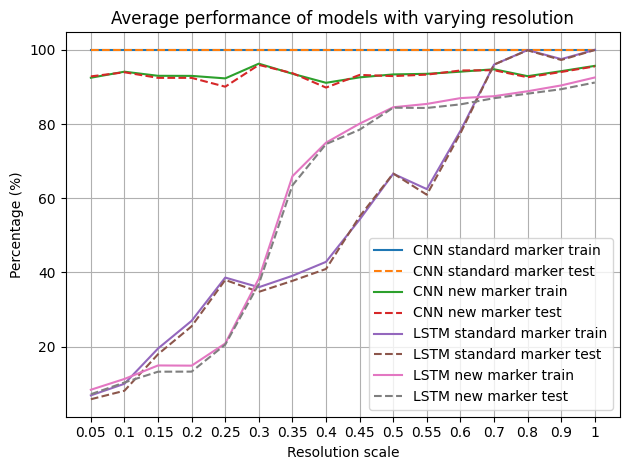

In [32]:
te_cnn=np.load(path+"/data/test_resolutions.npy")*100
tr_cnn=np.load(path+"/data/train_resolutions.npy")*100
te_cnn_n=np.load(path+"/data/test_resolutions_new.npy")*100
tr_cnn_n=np.load(path+"/data/train_resolutions_new.npy")*100

te_lstm=np.load(path+"/data/test_lstm_resolutions.npy")*100
tr_lstm=np.load(path+"/data/train_lstm_resolutions.npy")*100
te_lstm_n=np.load(path+"/data/test_lstm_resolutions_new.npy")*100
tr_lstm_n=np.load(path+"/data/train_lstm_resolutions_new.npy")*100

plt.plot(np.average(tr_cnn,axis=1),label="CNN standard marker train")
plt.plot(np.average(te_cnn,axis=1),"--",label="CNN standard marker test")
plt.plot(np.average(tr_cnn_n,axis=1),label="CNN new marker train")
plt.plot(np.average(te_cnn_n,axis=1),"--",label="CNN new marker test")
plt.plot(np.average(tr_lstm,axis=1),label="LSTM standard marker train")
plt.plot(np.average(te_lstm,axis=1),"--",label="LSTM standard marker test")
plt.plot(np.average(tr_lstm_n,axis=1),label="LSTM new marker train")
plt.plot(np.average(te_lstm_n,axis=1),"--",label="LSTM new marker test")
plt.grid(1)
plt.xlabel("Resolution scale")
plt.xticks([i for i in range(len(resolutions))],resolutions)
plt.ylabel("Percentage (%)")
plt.title("Average performance of models with varying resolution")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(path+"/images/resolution_models.pdf")
plt.show()

In [ ]:
torch.save(model.state_dict(), path+"/model/mymodel_lstm_cnn")
print(calc(model,test_loader))
print(calc(model,train_loader))

: 

### Look at resolution

In [ ]:
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
test_scores=np.zeros((len(resolutions),5))
train_scores=np.zeros((len(resolutions),5))
for i,res in enumerate(resolutions):
    print("RESOLUTIONS",i,"/",len(resolutions))
    for trial in range(5):
        train_loader,test_loader=genDataANN(0,4,res)
        model,history=runANN(train_loader,0,4)
        test_scores[i][trial]=calc(model,test_loader)
        train_scores[i][trial]=calc(model,train_loader)
        del train_loader
        del model
    np.save(path+"/saves/ANNresolutions_train",train_scores)
    np.save(path+"/saves/ANNresolutions_test",test_scores)


: 

In [ ]:
image=next(iter(train_loader))
print(image[0][0][0].shape)

: 

### Look at performance

In [ ]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model,history=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

: 

In [ ]:
#3d 
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=gen3DData(0,4)
    model,history=run3D(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except Exception as e:
    print(e)
    del train_loader
    del test_loader
    del model


: 

In [ ]:
plt.plot(history)
plt.show()
np.save("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/data/ubermodellstmcnn.pdf")

: 

In [ ]:
preds=None
real=None
keys=['Carpet', 'LacedMatt', 'wool', 'Cork', 'Felt', 'LongCarpet', 'Cotton', 'Plastic', 'Flat', 'Ffoam', 'Gfoam', 'bubble', 'Efoam', 'Jeans', 'Leather']
for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix/len(true_labels)

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(6, 6))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{round(value*100) if round(value*100,1) == 0.0 else round(value*100,1)}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([keys[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([keys[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.savefig(path+"/images/NM_confusionCNN.pdf")
plt.show()

: 

In [ ]:
torch.save(model.state_dict(), "C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodel")


: 

In [ ]:
model = SimpleCNN(abs(0-4)*110,120,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

: 

In [ ]:
#perform on unseen pressures

#load in numpy
data=np.load(datapath+"datasets/X_texture_pout.npz")
for array_name in data:
    x_unseen=(data[array_name].astype(np.uint8))
data=np.load(datapath+"datasets/y_texture_pout.npz")
for array_name in data:
    y_unseen=(data[array_name].astype(np.uint8))
print(x_unseen.shape)
#cut temporal size
x_unseen=x_unseen[:,0:4]
X=np.zeros_like(x_unseen)
#apply sobel filter
for i in range(len(x_unseen)): #crop all images individually
    for j in range(len(x_unseen[0])):
        image=x_unseen[i][j]
        # Apply Sobel filter in x-direction
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

        # Apply Sobel filter in y-direction
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Convert the results back to uint8
        sobel_x = np.uint8(np.absolute(sobel_x))
        sobel_y = np.uint8(np.absolute(sobel_y))

        # Combine the results to get the final edge-detected image
        sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
        X[i][j]=sobel_combined
unique_=["Flat","wool","Efoam","LongCarpet","LacedMatt","cotton","Gfoam","Carpet","felt","Ffoam","bubble","Cork","Jeans"]
keys={'Cork': 38, 'wool': 19, 'LacedMatt': 28, 'Gfoam': 30, 'Carpet': 31, 'bubble': 37, 'Efoam': 21, 'cotton': 29, 'LongCarpet': 25, 'Flat': 16, 'felt': 34, 'Jeans': 39, 'Ffoam': 36}
        
unique_={i:keys[unique_[i]] for i in range(len(unique_))}

#concat
X=X.reshape((4,len(X)//4,1,abs(0-4)*110,120))
X=torch.tensor(X, dtype=torch.float32).to(device)
y=y_unseen.reshape(4,len(y_unseen)//4)
print(X.shape,unique_)
#run through model
predsA=torch.argmax(model(X[0]),axis=1).detach().numpy()
predsB=torch.argmax(model(X[1]),axis=1).detach().numpy()
predsC=torch.argmax(model(X[2]),axis=1).detach().numpy()
predsD=torch.argmax(model(X[3]),axis=1).detach().numpy()
data=np.array([predsA,predsB,predsC,predsD])
for i,batch in enumerate(data):
    for key in np.unique(batch):
        batch[batch==key]=unique_[key]
data=data.reshape((len(x_unseen)))
y=y.reshape((len(x_unseen)))

#show accuracy (maybe confusion matrix of sorts)
correct=0
summed=0.1
a=data==y
summed+=len(x_unseen)
correct+=len(a[a==1])
print("Accuracy:",(correct/summed)*100,"%")

: 

### NUm of classes

In [24]:
train_loader,test_loader=genData(0,4)
#model,history=run(train_loader,0,4,num_epochs = 100)


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
Using 0.83 GB
torch.Size([2100, 1, 440, 120])
torch.Size([2100, 15])


/tmp/ipykernel_1575559/82541541.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


In [82]:
def filter_loaders_by_classes(train_loader, test_loader, n):
    # Get the class labels from the train_loader (assuming the label is in the second position of each batch)
    train_classes = []  # Use a set to automatically handle uniqueness
    for data, labels in train_loader:
        # Flatten the labels and update the set with unique labels
        l=np.argmax(labels.cpu().numpy().astype(np.uint8),axis=1)
        train_classes.append(l)  # Flatten to 1D and convert to numpy array
    train_classes=np.array(train_classes).flatten()
    
    train_classes = train_classes.tolist()  # Convert the set back to a list
    
    # Randomly select 'n' classes
    selected_classes = random.sample(train_classes, n)
    # Function to filter a loader by selected classes
    def filter_loader(loader, selected_classes):
        filtered_data = []
        filtered_labels = []

        for data, labels in loader:
            batch_size = data.size(0)  # Get the batch size
            # Iterate through the batch and check if any label in the sample matches the selected classes
            for i in range(batch_size):
                sample_labels = torch.argmax(labels[i])  # Labels for the i-th sample in the batch
                if sample_labels.cpu().item() in selected_classes:
                    filtered_data.append(data[i])  # Append the corresponding data sample
                    filtered_labels.append(labels[i])  # Append the corresponding labels

        # Convert lists back to tensors
        filtered_data = torch.stack(filtered_data) if filtered_data else torch.Tensor()
        filtered_labels = torch.stack(filtered_labels) if filtered_labels else torch.Tensor()
        # Return a new DataLoader with the filtered data
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(filtered_data, filtered_labels),
            batch_size=loader.batch_size
        )

    # Create the new filtered train and test loaders
    filtered_train_loader = filter_loader(train_loader, selected_classes)
    filtered_test_loader = filter_loader(test_loader, selected_classes)

    return filtered_train_loader, filtered_test_loader

test_acc=np.zeros((14,3))
train_acc=np.zeros((14,3))

for i in range(2,14):
    for j in range(3):
        print("Size",i,"trial",j)
        tl,tl2=filter_loaders_by_classes(train_loader, test_loader, i)
        model,history=run(tl,0,4,num_epochs = 100)
        test_acc[i][j]=calc(model,tl2)
        train_acc[i][j]=calc(model,tl)

np.save(path+"/data/test_acc_varying_dataset_size_optical_cnn",test_acc)
np.save(path+"/data/train_acc_varying_dataset_size_optical_cnn",train_acc)


Size 2 trial 0
Epoch [1/100], Step [6/6], Loss: 16.0950
Epoch [11/100], Step [6/6], Loss: 4.2697
Epoch [21/100], Step [6/6], Loss: 4.2233
Epoch [31/100], Step [6/6], Loss: 4.1906
Epoch [41/100], Step [6/6], Loss: 4.1505
Epoch [51/100], Step [6/6], Loss: 4.0925
Epoch [61/100], Step [6/6], Loss: 3.9888
Epoch [71/100], Step [6/6], Loss: 3.7805
Epoch [81/100], Step [6/6], Loss: 3.3616
Epoch [91/100], Step [6/6], Loss: 2.7688
Finished Training
Accuracy: 99.83079526226733 %
Accuracy: 99.9569151227919 %
Size 2 trial 1
Epoch [1/100], Step [6/6], Loss: 16.0490
Epoch [11/100], Step [6/6], Loss: 3.7838
Epoch [21/100], Step [6/6], Loss: 0.9541
Epoch [31/100], Step [6/6], Loss: 0.0930
Epoch [41/100], Step [6/6], Loss: 0.0379
Epoch [51/100], Step [6/6], Loss: 0.0220
Epoch [61/100], Step [6/6], Loss: 0.0148
Epoch [71/100], Step [6/6], Loss: 0.0110
Epoch [81/100], Step [6/6], Loss: 0.0086
Epoch [91/100], Step [6/6], Loss: 0.0070
Finished Training
Accuracy: 99.81515711645102 %
Accuracy: 99.954566106315

In [ ]:
#plot code for above


# Vis

In [ ]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()

: 

## Feature layer

In [ ]:
data=loaded(4,filename="X_data_newMorph.npz")
data.applySobel()
sample_of_data=data.X[0:10]

model = SimpleCNN(abs(4)*data.X.shape[2],data.X.shape[3],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel"))
model.eval()


x_data=data.X[0:4].reshape((len(data.X[0:4]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)


: 

In [ ]:

#forward pass
x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
print(x[0][0].shape)
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
axes = axes.flatten()
axes[0].imshow(train_images_tensor[0][0].cpu().detach().numpy(),cmap="gray")
axes[0].axis("off")
axes[0].set_title("Original image",fontsize=11)
for i in range(1,10):
    axes[i].imshow(x[2][i],cmap="gray")
    axes[i].axis("off")
    axes[i].set_title("Feature depth "+str(i+1),fontsize=11)
plt.tight_layout()
plt.savefig(path+"images/featuresALL_uberModel.pdf")
plt.show()

: 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data=loaded(t=4)
data.applySobel()
data.augment()

# Reduce dimensionality with PCA
pca = PCA(n_components=833)
x_data=data.X[0:].reshape((len(data.X[0:]),1,abs(4)*data.X.shape[2],data.X.shape[3]))
labels=data.y[0:]
print(x_data.reshape(len(x_data), -1).shape)
pca_features = pca.fit_transform(x_data.reshape(len(x_data), -1))

# Further reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_features)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title('t-SNE Visualization of Optical Tactile Sensor Images')
plt.savefig(path+"/images/clusters.pdf")
plt.show()

: 

# Point prediction

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p
sample=data.X[0:750]
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)+140
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()

: 

# Just points

In [ ]:
import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=5)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p


: 

In [ ]:
sample=data.X
print(sample.shape)
X_prime=np.zeros((len(sample),sample.shape[1],260,270),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2))
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        X_prime[i][j]=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=predict(reg,X_prime[i][j])[0]
X_alt=X_prime
X_alt[X_alt>255]=255
print(sample.shape,X_alt.shape)
plt.imshow(X_alt[0][0],cmap="gray")
pred=predict(reg,X_alt[0][0])[0]
plt.scatter(pred[:,0],pred[:,1])
plt.axis("off")
plt.savefig("/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/images/transfertogel.pdf")
plt.show()
del sample
del X_prime
del X_alt

: 

## FNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_layer1_size)
        
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)


        self.fc3 = nn.Linear(hidden_layer2_size, 50)
        
        # Define the output fully connected layer
        self.fc4 = nn.Linear(50, output_size)
    
    def forward(self, x):
        # Apply the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer followed by ReLU activation
        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        # Apply the output fully connected layer
        x = self.fc4(x)
        
        return x


: 

In [ ]:
X = np.round(coords.reshape((len(coords),-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
hidden_layer1_size = len(X[0]) //2  # Number of neurons in the first hidden layer
hidden_layer2_size = 800  # Number of neurons in the second hidden layer
output_size = len(un)     # Number of output features

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Print the model architecture
print(model)
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
print(X.shape,y.shape,X.dtype,y.dtype)
# Create a TensorDataset and DataLoader
#dataset = TensorDataset(torch.Tensor(train_X).to(device), torch.Tensor(train_y).to(device))
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
coords.reshape((len(coords),-1)).shape

: 

## LSTM

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class SimpleLSTMDrop(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(SimpleLSTMDrop, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

: 

In [ ]:
X = np.round(coords.reshape((len(coords),5,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 100, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

# Point velocities

In [ ]:
def plotchange(average):
    magnitudes=[]
    for t in range(len(average)-1):
        magnitudes.append(euclidean_distance(average[t],average[t+1]))
    ar=np.array(magnitudes).T
    return ar#(ar-np.min(ar))/(np.max(ar)-np.min(ar))

def euclidean_distance(point1, point2):
    # Convert points to numpy arrays
    point1 = np.array(point1)
    point2 = np.array(point2)
    
    # Calculate the distance
    distance = np.linalg.norm(point1 - point2,axis=1)
    
    return distance

#create dataset
d1=coords[:,:-1,:]
d2=coords[:,1:,:]
distances=np.linalg.norm(d1 - d2,axis=3)



: 

## LSTM

In [ ]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTM(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1200

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
X = distances
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleLSTMDrop(input_size, 300, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
inputs=torch.Tensor(test_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

## FNN

In [ ]:
X = distances.reshape((len(distances),-1))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X).to(device)
train_y_=torch.Tensor(train_y).to(device)

# Create the neural network
model = SimpleNeuralNetwork(input_size, hidden_layer1_size, hidden_layer2_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming a classification problem
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    #for inputs, labels in dataloader:
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_)
    
    # Calculate the loss
    loss = criterion(outputs, train_y_)
    
    # Backward pass
    loss.backward()
    
    # Optimize
    optimizer.step()
    if epoch%100==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X).to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

## CNN

In [ ]:
X = np.round(distances.reshape((len(distances),1,4,-1)))
X=(X-np.min(X))/(np.max(X)-np.min(X))
un=np.unique(data.y)
# Number of classes
num_classes = np.max(data.y) + 1
# One-hot encoding
one_hot_encoded = np.eye(num_classes)[data.y]
y=one_hot_encoded

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
input_size = len(X[0][0])       # Number of input features
output_size = len(un)     # Number of output features
print(X.shape,y.shape,X.dtype,train_X.shape)

train_X_=torch.Tensor(train_X)
train_y_=torch.Tensor(train_y)

# Model, loss function, optimizer
model = SimpleCNN(len(distances[0]),len(distances[0][0]))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_X_)
    optimizer.zero_grad()
    
    loss = criterion(outputs, train_y_)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


: 

In [ ]:
inputs=torch.Tensor(test_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(test_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")
inputs=torch.Tensor(train_X)#.to(device)
outputs = model(inputs)
outputs=outputs.cpu().detach().numpy()
print(test_y.shape,outputs.shape)
correct=np.argmax(train_y,axis=1)==np.argmax(outputs,axis=1)
print(np.sum(correct)/len(correct) *100,"%")

: 

In [ ]:
np.save(path+"/data/distances",distances)
np.save(path+"/data/distancesy",data.y)

: 

# Transferability of normal model 

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodelgel") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()
            

: 

In [ ]:

modelA = SimpleCNN(4*image.shape[0],image.shape[1]).to(device)
modelA.load_state_dict(torch.load(path+"/model/mymodelgel"))
modelA.eval()

: 

In [ ]:
print(calc(model,test_loader))
print(calc(model,train_loader))

import pickle
with open('/its/home/drs25/Documents/GitHub/RoboSkin/Code/Models/TacTip reader/pickle_imputer_sobel.pkl','rb') as file:
    reg=pickle.load(file)
data=loaded(t=4)
data.applySobel()
def predict(reg,dat):
    dat=dat.flatten()
    p=reg.predict([dat])
    p=p.reshape((p.shape[0],p.shape[1]//2,2))
    return p

: 

In [ ]:
sample=data.X[0:300]
X_prime=np.zeros((len(sample),sample.shape[1],*data.X[0][0].shape),dtype=np.uint8)
coords=np.zeros((len(sample),sample.shape[1],133,2)).astype(np.uint16)
divh=X_prime[0][0].shape[0]/270
divw=X_prime[0][0].shape[1]/260
print(divh,divw,X_prime[0][0].shape)
for i in range(len(sample)): #create data aas linear images
    for j in range(len(sample[0])):
        temp=cv2.resize(sample[i][j],(270,260),interpolation=cv2.INTER_AREA)#+10
        coords[i][j]=np.round(predict(reg,temp)[0])
        #X_prime[i][j]*=0 
        for point in zip(coords[i][j][:,0],coords[i][j][:,1]):
            p1=int(point[0]*divh)
            p2=int(point[1]*divw)
            cv2.circle(X_prime[i][j],(p1,p2),1,(255),2)
del sample

: 

In [ ]:
plt.imshow(X_prime[0][0],cmap="gray")
plt.show()
plt.imshow(data.X[0][0],cmap="gray")
plt.show()

: 

In [ ]:
x=(X_prime-np.mean(X_prime))/(np.max(X_prime)-np.min(X_prime))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))
print(x.shape)
test=torch.tensor(x, dtype=torch.float32)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")


: 

# saliency maps

In [ ]:
data=loaded(4,filename="X_data_nomarker.npz")
data.applySobel()

: 

In [ ]:
image=data.X[0][0]
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodelnomarker"))
model.eval()
n=10


: 

In [ ]:
#look at frquency 
def generate_saliency_maps(model, inputs, target_class):
    model.eval()
    inputs.requires_grad = True  # Ensure gradients can be computed for input

    # Forward pass to get the predictions
    outputs = model(inputs)  # outputs should be of shape (N, num_classes) if model outputs logits
    score = outputs[:, target_class].sum()  # Sum over the batch for a single target class
    
    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward()
    
    # Get the absolute value of the gradients as saliency map
    saliency = inputs.grad.abs()  # Shape will be (N, t, w, h)

    return saliency

# Plotting Function
def plot_saliency_map(saliency, original_frames, time_index):
    """Plot saliency map for a specific time index in the sequence"""
    # Average over the batch if needed, to show a single example
    saliency_frame = saliency[0, time_index].detach().cpu().numpy()  # Shape (w, h)
    original_frame = original_frames[0, time_index].detach().cpu().numpy()
    
    # Normalize saliency map for visualization
    saliency_frame = (saliency_frame - saliency_frame.min()) / (saliency_frame.max() - saliency_frame.min())
    
    # Plot the original frame with saliency map overlay
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].imshow(original_frame[0:110,:], cmap='gray')
    ax[0].set_title("Original Frame",fontsize=15,**csfont)
    ax[0].axis('off')
    ax[1].imshow(original_frame[0:110,:], cmap='gray')
    ax[1].imshow(saliency_frame[0:110,:], cmap='hot', alpha=0.5)  # Overlay saliency map
    ax[1].set_title(f"Saliency Map - Frame {time_index}",fontsize=15,**csfont)
    ax[1].axis('off')
    plt.tight_layout()
    plt.savefig(path+"/images/saliency_map.pdf")
    plt.show()

# Load a sample from your dataset
shape=data.X[0].shape
n=10
sample_input = torch.tensor(data.X[0:n],dtype=torch.float32).reshape((len(data.X[0:n]),1,4*data.X.shape[2],data.X.shape[3]))  # Shape (1, t, w, h) - single sample for visualization

print(sample_input.shape)
# Generate saliency maps for the sample
target_class = 0  # Replace with the class index of interest
saliency_maps = generate_saliency_maps(model, sample_input, target_class)

# Plot saliency for each frame in the temporal sequence
for time_index in range(sample_input.shape[1]):  # Iterate over t frames
    plot_saliency_map(saliency_maps, sample_input, time_index)

: 

## Taking out segments



In [ ]:
data=loaded(4,filename="X_data_15.npz")
data.applySobel()

: 

In [ ]:

sample=data.X[0:300].reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
images=[sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy(),sample[0][0].copy()]
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
label=["50:75","20:45","70:95","60:70","Segment removed","Two removed","Three removed","Only first and last"]
label=["A","B","C","D","E","F","G","H"]
sample[:,0:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy()

fig, axes = plt.subplots(1, len(images), figsize=(15,8))
axes = axes.flatten()
for i in range(len(images)):
    axes[i].set_title(label[i],fontsize=30,**csfont)
    axes[i].imshow(images[i])
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(path+"/images/samplesCrops_.pdf")
plt.show()


: 

In [ ]:
sample=data.X[0:300].reshape((300,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()
"""
images[0][0:-1,50:75]=0
images[1][0:-1,20:45]=0
images[2][0:-1,70:95]=0
images[3][0:-1,60:70]=0
images[4][0:110,0:120]=0
images[5][0:220,0:120]=0
images[6][0:330,0:120]=0
images[7][110:330,0:120]=0
"""
sample[:,110:330,0:120]=0
#sample=sample.reshape((300,4,len(data.X[0][0])*len(data.X[0][0][0]))).copy() # lstm
sample=sample.reshape((300,1,4*len(data.X[0][0]),len(data.X[0][0][0]))).copy()

image=sample[0][0]
print(image.shape)
#model=SimpleCNN(data.X.shape[2]*4,data.X.shape[3],15).to(device)#.half()
"""model=SimpleLSTM(image.shape[1],1000,15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()"""
model = SimpleCNN(image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/mymodel_newMorph"))
model.eval()
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
#x=x.reshape((len(x),4,x.shape[2]//4*x.shape[3]))

print(x.shape)
test=torch.tensor(x, dtype=torch.float32).to(device)
print(test.dtype)
label=data.y[0:300]
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=np.abs(label-preds)
print(len(a[a==0])/len(a) *100,"%")
plt.imshow(image.reshape((4*len(data.X[0][0]),len(data.X[0][0][0]))))
plt.show()

: 

In [ ]:
matrixA=np.array([[56.3,98,99.3],[52,100,53.3],[72.3,100,70],[89.33,100,100],[98.6,100,95.6],[91.3,100,64.6],[83.3,97,47.3],[97,100,79.6]]) #cnn
matrixB=np.array([[43.4,63,100],[19.3,92.6,12.3],[23.3,86,83.6],[88.6,90.3,100],[86,68.3,86.3],[72.6,45,56.9],[49,34,32.6],[68.6,61.6,60]])
fig, ax = plt.subplots(figsize=(10, 6))

# Plot matrixA in the top half with 'YlGn' colormap
ax.imshow(matrixA.T, cmap='YlGn', aspect='auto', extent=[0, 8, 6, 3])

# Plot matrixB in the bottom half with 'gray' colormap
ax.imshow(matrixB.T, cmap='YlOrRd', aspect='auto', extent=[0, 8, 3, 0])

# Set ticks
ax.set_xticks(np.arange(8) + 0.5)
ax.set_xticklabels(["A","B","C","D","E","F","G","H"],fontsize=20,**csfont)
ax.set_yticks(np.arange(6)+1)
ax.set_yticklabels(["  NM", "  S", "  0M", "  NM", "  S", "  0M"], rotation=90, ha="left", rotation_mode="anchor",fontsize=20,**csfont)


# Add text annotations
for i in range(matrixA.shape[0]):
    for j in range(matrixA.shape[1]):
        ax.text(i+0.5, j+0.5+3, f"{matrixA[i, j]:.1f}%", ha='center', va='center', color='white' if matrixA[i, j] > 70 else 'black',fontsize=18,**csfont)

for i in range(matrixB.shape[0]):
    for j in range(matrixB.shape[1]):
        ax.text(i+0.5, j+0.5, f"{matrixB[i, j]:.1f}%", ha='center', va='center', color='white' if matrixB[i, j] > 90 else 'black',fontsize=18,**csfont)


plt.title("Model results",fontsize=20,**csfont)
plt.tight_layout()
plt.savefig(path+"/images/LSTM_different_markers.pdf")
plt.show()

: 

# Different pressures

In [ ]:
train_loader,test_loader,unique=genData(0,4)
model,history=run(train_loader,0,4)
torch.save(model.state_dict(), path+"/model/mymodel_withLowPressure") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")
data=loaded(4)
image=data.X[0][0]
print(calc(model,test_loader))
print(calc(model,train_loader))

: 

In [ ]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodel_lstm"))
model.eval()
#print(calc(model,test_loader))
#print(calc(model,train_loader))

: 

In [ ]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_flat_unseen_pressures.npz")
d.applySobel()
sample=d.X
label=d.y


: 

In [ ]:
sample=d.X
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),x.shape[1],x.shape[2]*x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds[preds==11]
print(len(a)/len(preds) *100,"%")
del test
del x

: 

In [ ]:
p20=d.X[np.where(d.y==3)]
p30=d.X[np.where(d.y==0)]
p40=d.X[np.where(d.y==2)]
p50=d.X[np.where(d.y==1)]
data=[p20,p30,p40,p50]
accs=[]
for i in range(4):
    sample=data[i]
    label=11
    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))  #n,1,t*h,w for cnn, n,t,h*w for lstm, n,1,t,h,w for cnn-lstm
    test=torch.tensor(x, dtype=torch.float32).to(device)
    preds=model(test)
    preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
    a=len(preds[preds==label])
    print(a/len(preds) *100,"%")

: 

# models on other data sets

In [ ]:
data=loaded(4,filename="X_data_nomarker.npz")
image=data.X[0][0].copy()
del data
#model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#print(calc(model,test_loader))
#print(calc(model,train_loader))

: 

In [ ]:
#model=SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
#model=SimpleLSTM(image.shape[0]*image.shape[1],1000,15).to(device)
model=CNN_LSTM(image.shape[1],image.shape[0],1000,1,15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_lstmCNN"))
model.eval()

: 

In [ ]:
torch.cuda.empty_cache()
d=loaded(t=4,filename="X_data_nomarker.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
sample=d.X[0:800]
label=d.y[0:800]
del d
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1],x.shape[2],x.shape[3]))
test=torch.tensor(x, dtype=torch.float32).to(device)
preds=model(test)
preds=torch.argmax(preds,axis=1).cpu().detach().numpy()
a=preds-label
print(len(a[a==0])/len(preds) *100,"%")
del test
del x


: 

# Transferring large models to small

In [ ]:
data=loaded(4,filename="X_data_15.npz")
image=data.X[0][0]
data
model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
model.load_state_dict(torch.load(path+"/model/uber_model"))
model.eval()

: 

In [ ]:
d=loaded(t=4,filename="X_data_15.npz") #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
d.applySobel()
d.resize(0.1)

sample=d.X
sampley=d.y
image=sample[0][0]
print(image.shape)
#copy over correct convolutions
modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],15).to(device)
modelB.conv1=model.conv1
modelB.conv2=model.conv2
#freeze conv layers
modelB.conv1.requires_grad=False
modelB.conv2.requires_grad=False


: 

In [ ]:


label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(sampley)
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)


: 

In [ ]:
#train
train_history=[]
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(modelB.parameters(), lr=0.005)

# Train the Model
num_epochs=50
clip_value = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = modelB(inputs)
        #print(inputs.shape,outputs.shape,labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    train_history.append(loss.cpu().detach().numpy())
    if epoch%10==0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
print('Finished Training')

: 

In [ ]:
print(calc(modelB,test_loader))
print(calc(modelB,train_loader))

: 

In [ ]:
#GEL
# 5%
# train % 58.95 test 57.99 % 

#10%
# train % 91.70 test 92.81 % 

#15%
# train % 93.37 test 94.81

#20%
# train % 96.99 test 98.15

#25%
# train % 99.9 test 99.98 % 

#NEWMORPH
# 5%
# train % 74.32 test 75.37 % 

#10%
# train % 89.17 test 89.02 % 

#15%
# train % 82.92 test 84.98 %

#20%
# train % 96.87 test 95.75 %

#25%
# train % 90.1 test 88.25 % 

#SILICONE
# 5%
# train % - test - % 

#10%
# train % - test - % 

#15%
# train % 79 test 74 %

#20%
# train % 88 test 90 %

#25%
# train % - test - % 

: 

## automate

In [ ]:
#automate the shit out of it
def long(file,type1,num):
    resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
    acc_test=np.zeros((len(resolution),5))
    acc_train=np.zeros((len(resolution),5))
    num_epochs=80
    history=np.zeros((len(resolution),5,num_epochs))

    for i in range(len(resolution)):
        d=loaded(t=4,filename=file) #X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
        d.applySobel()
        image=d.X[0][0]
        model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
        model.load_state_dict(torch.load(path+"/model/mymodelgel"))
        model.eval()
        d.resize(resolution[i])
        
        sample=d.X
        sampley=d.y
        image=sample[0][0]
        print(image.shape)
        
        #copy over correct convolutions
        modelB=SimpleCNN(image.shape[0]*d.X.shape[1],image.shape[1],num).to(device)
        modelB.conv1=model.conv1
        modelB.conv2=model.conv2
        #freeze conv layers
        modelB.conv1.requires_grad=False
        modelB.conv2.requires_grad=False


        label_encoder = LabelEncoder()
        train_labels_encoded = label_encoder.fit_transform(sampley)
        one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
        x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
        x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

        train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

        # Create a TensorDataset
        dataset = TensorDataset(train_images_tensor, train_labels_tensor)
        # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        # Create DataLoader for training and testing sets
        train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
        max_=0
        for j in range(5):
            clear_output(wait=True)
            print("Resolution",resolution[i],"Trial",j)
            criterion = nn.CrossEntropyLoss().to(device)
            optimizer = optim.SGD(modelB.parameters(), lr=0.005)

            # Train the Model
            
            clip_value = 5
            for epoch in range(num_epochs):
                running_loss = 0.0
                for k, (inputs, labels) in enumerate(train_loader):
                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = modelB(inputs)
                    #print(inputs.shape,outputs.shape,labels.shape)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(modelB.parameters(), clip_value)
                    optimizer.step()

                    # Print statistics
                    running_loss += loss.item()
                history[i][j][epoch]=running_loss/(k+1) #save average loss per epoch
            test=calc(modelB,test_loader)
            train=calc(modelB,train_loader)
            acc_train[i][j]=train
            acc_test[i][j]=test
            if test>max_:
                max_=test
                torch.save(modelB.state_dict(), path+"/model/standard_c_gel/cnn_res"+str(resolution[i])+"_"+str(type1))
        del train_loader
        del test_loader
    
    np.save(path+"/data/train_uber_"+type1+"_long_standard_c",acc_train)
    np.save(path+"/data/test_uber_"+type1+"_long_standard_c",acc_test)
    np.save(path+"/data/histroy_"+type1+"_long_standard_c",history)

#X_data_gel_15.npz X_data_newMorph.npz X_data_15.npz
long("X_data_gel_15.npz","gel",15)
#long("X_data_15.npz","sil",15)
#long("X_data_newMorph.npz","nm",13)


: 

## vis

In [ ]:
sil_train=np.load(path+"/data/train_uber_sil_long_standard_c.npy")
sil_test=np.load(path+"/data/test_uber_sil_long_standard_c.npy")
gel_train=np.load(path+"/data/train_uber_gel_long_standard_c.npy")
gel_test=np.load(path+"/data/test_uber_gel_long_standard_c.npy")
#nm_train=np.load(path+"/data/train_uber_nm_long.npy")
#nm_test=np.load(path+"/data/test_uber_nm_long.npy")

average_sil_test=np.average(sil_test,axis=1)*100
max_sil_test=np.max(sil_test,axis=1)*100
average_sil_train=np.average(sil_train,axis=1)*100
average_gel_test=np.average(gel_test,axis=1)*100
max_gel_test=np.max(gel_test,axis=1)*100
average_gel_train=np.average(gel_train,axis=1)*100
#average_nm_test=np.average(nm_test,axis=1)*100
#max_nm_test=np.max(nm_test,axis=1)*100
#average_nm_train=np.average(nm_train,axis=1)*100

plt.plot(average_sil_test,c="b",label="Silicone test")
plt.plot(max_sil_test,"--",c="b",label="Silicone max")
plt.plot(average_gel_test,c="g",label="Gel test")
plt.plot(max_gel_test,"--",c="g",label="Gel max")
#plt.plot(average_nm_test,c="r",label="NM test")
#plt.plot(max_nm_test,"--",c="r",label="NM max")

#plt.plot(average_sil_train,c="b",label="Silicone train")
resolution=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8]
plt.xticks([i for i in range(len(resolution))],resolution)
plt.ylabel("Aacuracy %")
plt.xlabel("Resolution multiplier")
plt.title("Resolution vs accuracy on pretrained conv layer",fontsize=14)
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig(path+"/images/resolution_just_own_transfer.pdf")
plt.show()

: 

In [ ]:
import matplotlib.cm as cm

sil_history=np.load(path+"/data/histroy_sil_long_untrained.npy")
gel_history=np.load(path+"/data/histroy_gel_long_untrained.npy")
nm_history=np.load(path+"/data/histroy_nm_long_untrained.npy")
print(sil_history.shape)

sil_history_av=np.average(sil_history,axis=1)
#gel_history_av=np.average(gel_history,axis=1)
#nm_history_av=np.average(nm_history,axis=1)
print(sil_history_av.shape)
# Create a colormap that gets darker
colors = cm.viridis(np.linspace(0, 1, len(resolution)))

for i in range(len(sil_history_av)):
    plt.plot(sil_history_av[i],color=colors[i],label="Resolution "+str(resolution[i]))
#plt.plot(gel_history_av,label="Average loss gel")
#plt.plot(nm_history_av,label="Average loss new morphology")
plt.title("Loss over training")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.grid(True)
plt.legend(loc="upper right")
plt.savefig(path+"/images/resolution_loss_untrained.pdf")
plt.show()

: 

## Feature layers

In [ ]:
images_X=[]
images_f=[]
images_o=[]
for i in range(len(resolution)-1):
    filename="cnn_res"+str(resolution[i])+"_gel"

    data=loaded(4,filename="X_data_15.npz")
    data.applySobel()
    data.resize(resolution[i])
    image=data.X[0][0]

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/res/"+filename))
    model.eval()

    sample=data.X[0:13]
    sampley=data.y[0:13]

    x=(sample-np.mean(sample))/(np.max(sample)-np.min(sample))
    x=x.reshape((len(x),1,x.shape[1]*x.shape[2],x.shape[3]))

    train_images_tensor = torch.tensor(x, dtype=torch.float32).to(device)

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_X.append(train_images_tensor[0][0].cpu().detach().numpy())
    images_f.append(x.copy())

    model = SimpleCNN(4*image.shape[0],image.shape[1],output=15).to(device)
    model.load_state_dict(torch.load(path+"/model/learnedres/"+filename))
    model.eval()

    #preds=torch.argmax(model(train_images_tensor)).cpu().detach().numpy()
    x = model.pool(model.relu(model.conv1(train_images_tensor)))#.cpu().detach().numpy()
    x = model.pool(model.relu(model.conv2(x))).cpu().detach().numpy()
    images_o.append(x.copy())


: 

In [ ]:

fig, axes = plt.subplots(3, len(resolution)-1, figsize=(10, 8))
#axes = axes.flatten()

for i in range(len(images_X)):
    axes[0][i].imshow(images_X[i],cmap="gray")
    axes[0][i].axis("off")
    axes[0][i].set_ylabel("Original res "+str(resolution[i]),fontsize=11)
    #print(images_f[i][0].shape)
    axes[1][i].imshow(images_f[i][0][0],cmap="gray")
    axes[1][i].axis("off")
    #axes[1][i].set_title("Feature res"+str(resolution[i]),fontsize=11)
    axes[2][i].imshow(images_o[i][1][0],cmap="gray")
    axes[2][i].axis("off")

plt.tight_layout()
plt.savefig(path+"images/features_norm_transfer.pdf")
plt.show()

: 

# playing with points

In [7]:
data=loaded(t=10)
data.applySobel()

data2=loaded(filename="X_data_newMorph.npz",t=10)
data2.applySobel()

data3=loaded(filename="X_data_nomarker.npz",t=10)
data3.applySobel()

#data.augment()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [8]:
def compute_dense_optical_flows(dataset):
    n, t, h, w = dataset.shape
    optical_flows = np.zeros((n, t-1, h, w), dtype=np.uint8)  # Change to uint8 for 0-255 range
    
    # Optical flow parameters for higher sensitivity
    pyr_scale = 0.1     # Lowered for more sensitivity to small movements
    levels = 20         # Increased number of pyramid levels
    winsize = 5         # Reduced window size for finer detail
    iterations = 6      # More iterations per level
    poly_n = 5          # Polynomial window size (typically fixed)
    poly_sigma = 1.0    # Lowered for more detailed flow calculations
    
    for i in range(n):  # Loop over each sample
        for j in range(t - 1):  # Loop over each pair of frames
            # Convert frames to grayscale if needed
            frame1 = dataset[i, j].astype(np.uint8)
            frame2 = dataset[i, j + 1].astype(np.uint8)
            
            # Calculate dense optical flow with more sensitive parameters
            flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 
                                                pyr_scale, levels, winsize, 
                                                iterations, poly_n, poly_sigma, 0)
            
            # Calculate the magnitude and angle of the flow
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            
            # Normalize the magnitude to the range 0-255 and convert to uint8
            mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            optical_flows[i, j] = mag  # Store the normalized magnitude

    return optical_flows


def compute_dense_optical_flows(dataset):
    n, t, h, w = dataset.shape
    optical_flows = np.zeros((n, t-1, h, w), dtype=np.uint8)  # Change to uint8 for 0-255 range
    
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    for i in range(n):  # Loop over each sample
        for j in range(t - 1):  # Loop over each pair of frames
            # Convert frames to grayscale if needed
            frame1 = dataset[i, j].astype(np.uint8)
            frame2 = dataset[i, j + 1].astype(np.uint8)
            
            # Detect good features to track in the first frame
            p0 = cv2.goodFeaturesToTrack(frame1, mask=None, maxCorners=500, qualityLevel=0.01, minDistance=5)
            
            # Calculate optical flow using Lucas-Kanade
            p1, st, err = cv2.calcOpticalFlowPyrLK(frame1, frame2, p0, None, **lk_params)
            
            # Filter only good points where flow is successfully calculated
            if p1 is not None:
                good_new = p1[st == 1]
                good_old = p0[st == 1]
                
                # Create a mask to draw the optical flow vectors
                mask = np.zeros_like(frame1, dtype=np.uint8)
                
                # Draw the optical flow vectors
                for (new, old) in zip(good_new, good_old):
                    a, b = new.ravel()
                    c, d = old.ravel()
                    cv2.line(mask, (int(c), int(d)), (int(a), int(b)), 255, 1)
                    
                # Store the mask as the flow field representation for this pair of frames
                optical_flows[i, j] = mask

    return optical_flows
    
flow_data=compute_dense_optical_flows(data.X)
flow_data2=compute_dense_optical_flows(data2.X)
flow_data3=compute_dense_optical_flows(data3.X)


In [9]:
def augment(dataset, y, segment_size=0.2):
    n, t, h, w = dataset.shape
    
    # Create an empty array for the augmented data
    augmented_data = dataset.copy()
    
    for i in range(n):
        for j in range(t):
            # Randomly determine the segment's position and size
            seg_h = int(h * segment_size)
            seg_w = int(w * segment_size)
            start_h = np.random.randint(0, h - seg_h)
            start_w = np.random.randint(0, w - seg_w)
            
            # Remove (mask) the segment in the image
            augmented_data[i, j, start_h:start_h + seg_h, start_w:start_w + seg_w] = 0
    
    # Concatenate the original and augmented data
    combined_data = np.concatenate((dataset, augmented_data), axis=0)
    
    # Duplicate the labels for the augmented dataset
    combined_y = np.concatenate((y, y), axis=0)
    
    # Shuffle the combined dataset and labels together
    indices = np.arange(2 * n)
    np.random.shuffle(indices)
    combined_data = combined_data[indices]
    combined_y = combined_y[indices]
    
    return combined_data, combined_y

flow_data_a,flow_y=augment(flow_data,data.y)
#flow_data_a,flow_y=augment(np.concatenate([flow_data,flow_data2,flow_data3]),np.concatenate([data.y,data2.y,data3.y]))
flow_data_a,flow_y=augment(flow_data_a,flow_y)
flow_data_a,flow_y=augment(flow_data_a,flow_y)
#flow_data_a,flow_y=augment(flow_data2,data2.y)
#flow_data_a=flow_data
#flow_y=data.y

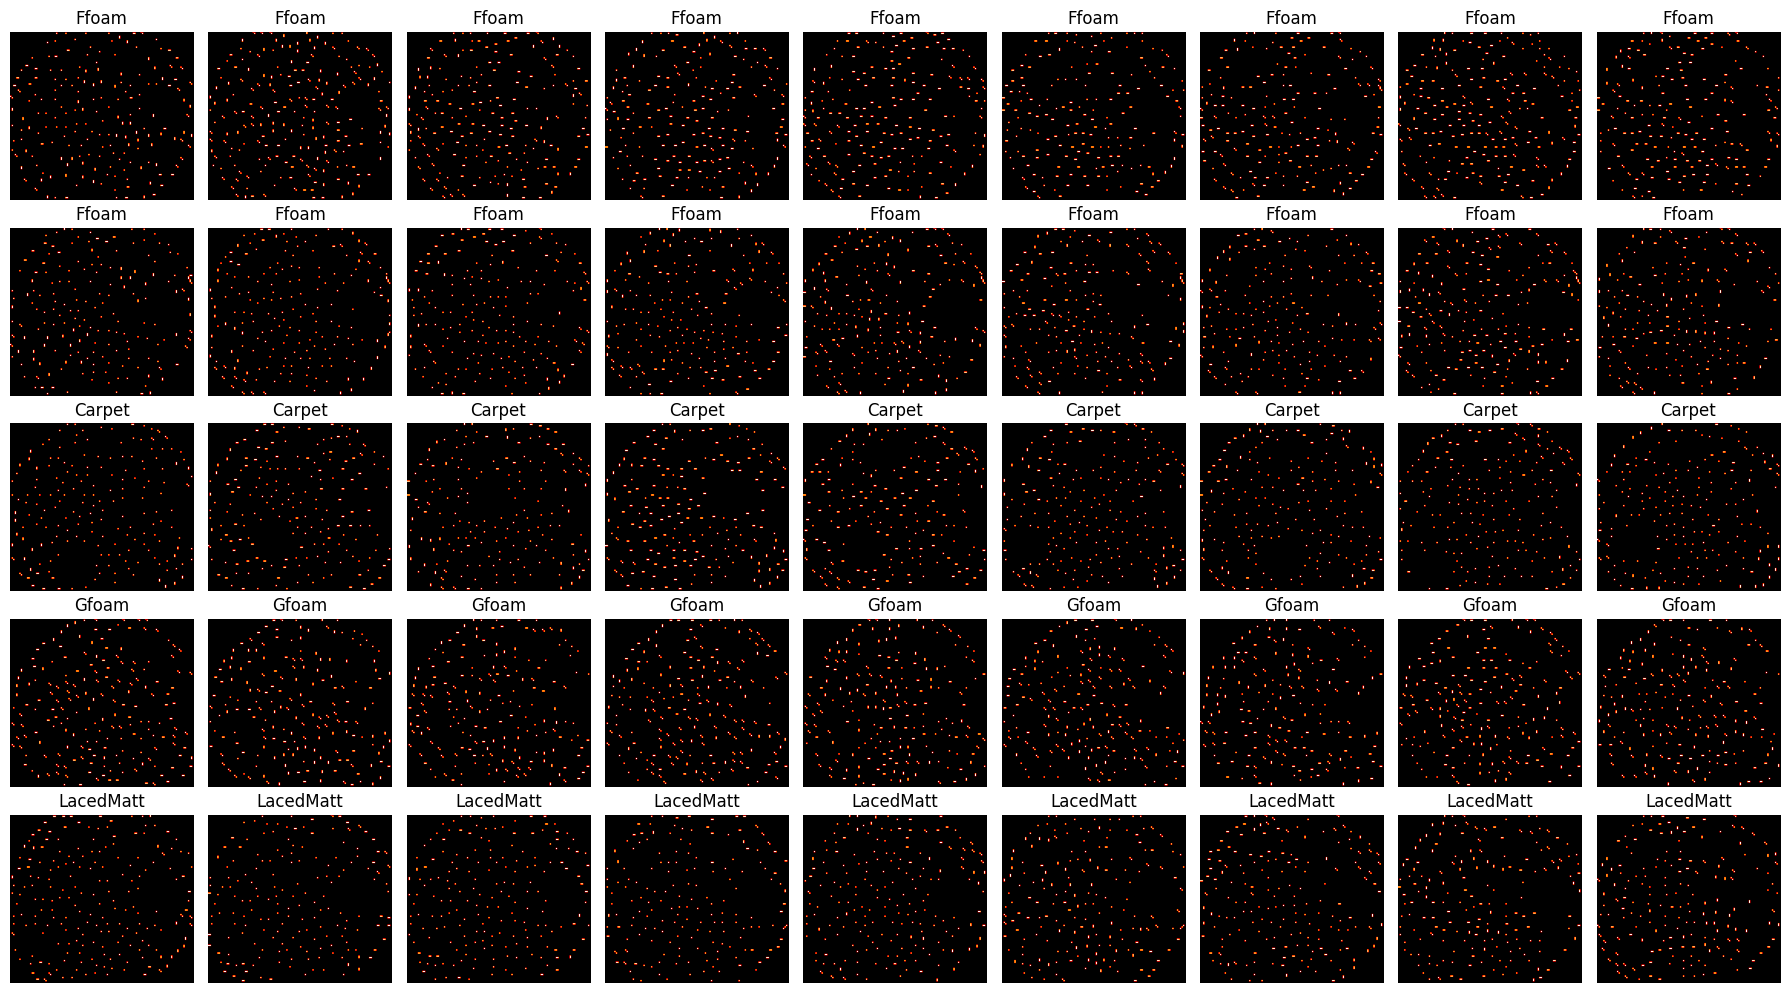

In [9]:
def plot_images_grid(images_grid,data):
    """
    Plots a grid of images, where each sublist in images_grid represents a row of images.
    
    Parameters:
    images_grid (list of lists): List of lists where each sublist contains images for a row.
    """
    num_rows = len(images_grid)
    num_cols = max(len(row) for row in images_grid)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    
    # Flatten axes if there's only one row or column for consistency
    if num_rows == 1:
        axes = [axes]
    if num_cols == 1:
        axes = [[ax] for ax in axes]
    c=0
    # Plot each image in the correct position
    for row_idx, row_images in enumerate(images_grid):
        for col_idx, img in enumerate(row_images):
            ax = axes[row_idx][col_idx]
            ax.set_title(data.keys[data.y[c]])
            ax.imshow(img, cmap='gist_heat' if img.ndim == 2 else None)
            ax.axis('off')  # Hide the axes for a cleaner look
        c+=1
    # Hide any unused subplots if the rows have different lengths
    for row_idx in range(num_rows):
        for col_idx in range(len(images_grid[row_idx]), num_cols):
            axes[row_idx][col_idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_grid(flow_data_a[0:5],data)

## train network on this

In [16]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),1,abs(flow_data_a.shape[1])*flow_data_a.shape[2],flow_data_a.shape[3]))
x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
del x_data
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
model,history=run(train_loader,0,4,num_epochs = 100)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodelcnn_optic_flow") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

/tmp/ipykernel_1598864/836657166.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [480/480], Loss: 1117.2915
Epoch [11/100], Step [480/480], Loss: 0.4085
Epoch [21/100], Step [480/480], Loss: 0.1551
Epoch [31/100], Step [480/480], Loss: 0.0913
Epoch [41/100], Step [480/480], Loss: 0.0633
Epoch [51/100], Step [480/480], Loss: 0.0479
Epoch [61/100], Step [480/480], Loss: 0.0383
Epoch [71/100], Step [480/480], Loss: 0.0317
Epoch [81/100], Step [480/480], Loss: 0.0270
Epoch [91/100], Step [480/480], Loss: 0.0234
Finished Training
Accuracy: 99.99791671006854 %
0.9999791671006854
Accuracy: 99.99947914225147 %
0.9999947914225147


### lstm

In [37]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),abs(flow_data_a.shape[1]),flow_data_a.shape[2]*flow_data_a.shape[3]))
#x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
x/=255
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
del x_data
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)
model,history=runLSTM(train_loader,0,10,num_epochs = 200)
print(calc(model,test_loader))
print(calc(model,train_loader))
torch.save(model.state_dict(), path+"/model/mymodellstm_optic_flow") #"/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/model/mymodelgel")

/tmp/ipykernel_1594693/4159573806.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/200], Step [120/120], Loss: 324.6456
Epoch [11/200], Step [120/120], Loss: 318.7175
Epoch [21/200], Step [120/120], Loss: 292.4398
Epoch [31/200], Step [120/120], Loss: 218.4090
Epoch [41/200], Step [120/120], Loss: 157.8653
Epoch [51/200], Step [120/120], Loss: 91.5385
Epoch [61/200], Step [120/120], Loss: 40.7039
Epoch [71/200], Step [120/120], Loss: 14.5386
Epoch [81/200], Step [120/120], Loss: 6.3397
Epoch [91/200], Step [120/120], Loss: 3.7677
Epoch [101/200], Step [120/120], Loss: 2.5890
Epoch [111/200], Step [120/120], Loss: 1.9344
Epoch [121/200], Step [120/120], Loss: 1.5251
Epoch [131/200], Step [120/120], Loss: 1.2475
Epoch [141/200], Step [120/120], Loss: 1.0491
Epoch [151/200], Step [120/120], Loss: 0.9001
Epoch [161/200], Step [120/120], Loss: 0.7854
Epoch [171/200], Step [120/120], Loss: 0.6945
Epoch [181/200], Step [120/120], Loss: 0.6211
Epoch [191/200], Step [120/120], Loss: 0.5606
Finished Training
Accuracy: 98.82509790850763 %
0.9882509790850763
Accuracy: 9

In [10]:
n=-1
x_data=flow_data[0:n].reshape((len(flow_data[0:n]),abs(flow_data.shape[1]),flow_data.shape[2]*flow_data.shape[3]))
image=x_data[0][0]
model = SimpleLSTM(image.shape[0],350,15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodellstm_optic_flow"))
model.eval()

/tmp/ipykernel_1598864/1168738564.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodellstm_optic_flow"))


RuntimeError: Error(s) in loading state_dict for SimpleLSTM:
	Unexpected key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1", "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2". 

In [9]:
n=-1
x_data=flow_data[0:n].reshape((len(flow_data[0:n]),1,abs(flow_data.shape[1])*flow_data.shape[2],flow_data.shape[3]))
image=x_data[0][0]
model = SimpleCNN(image.shape[0],image.shape[1],15).to(device)#.half()
model.load_state_dict(torch.load(path+"/model/mymodelcnn_optic_flow"))
model.eval()

/tmp/ipykernel_1599463/2210332082.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path+"/model/mymodelcnn_optic_flow"))


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=74100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=15, bias=True)
  (relu): ReLU()
)

In [26]:
sample=200
torch.cuda.empty_cache()
x=torch.tensor(flow_data2.reshape((flow_data2.shape[0],flow_data2.shape[1],flow_data2.shape[2]*flow_data2.shape[3])), dtype=torch.float32).to(device) #lstm
#x=torch.tensor(flow_data2.reshape((flow_data2.shape[0],1,flow_data2.shape[1]*flow_data2.shape[2],flow_data2.shape[3])), dtype=torch.float32).to(device) #cnn
x/=255
#x=(x-torch.mean(x))/(torch.max(x)-torch.min(x)) #preprocessing
preds=model(x[0:sample])
vals=torch.argmax(preds,axis=1).cpu().detach().numpy()
error=np.abs(vals-data2.y[0:sample])

print("Accuracy ",len(np.where(error==0)[0]),"/400",":",len(np.where(error==0)[0])/400 *100,"%")

Accuracy  24 /400 : 6.0 %


In [27]:
torch.cuda.empty_cache()
sample=200
x=torch.tensor(flow_data3.reshape((flow_data3.shape[0],flow_data3.shape[1],flow_data3.shape[2]*flow_data3.shape[3])), dtype=torch.float32).to(device) #lstm
#x=torch.tensor(flow_data3.reshape((flow_data3.shape[0],1,flow_data3.shape[1]*flow_data3.shape[2],flow_data3.shape[3])), dtype=torch.float32).to(device) #cnn
x/=255
#x=(x-torch.mean(x))/(torch.max(x)-torch.min(x)) #preprocessing
preds=model(x[0:sample])
vals=torch.argmax(preds,axis=1).cpu().detach().numpy()
error=np.abs(vals-data3.y[0:sample])

print("Accuracy ",len(np.where(error==0)[0]),"/400",":",len(np.where(error==0)[0])/400 *100,"%")

Accuracy  19 /400 : 4.75 %


## transformers

In [10]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Embedding layer to convert inputs to model dimension
        self.embedding = nn.Linear(input_dim, model_dim)
        
        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer to map to number of classes
        self.fc_out = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        # Apply embedding
        x = self.embedding(x)
        
        # Transformer encoder expects input as (sequence_length, batch_size, model_dim)
        x = x.permute(1, 0, 2)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)
        
        # Get the mean of the output sequence (global average pooling)
        x = x.mean(dim=0)
        
        # Output layer
        output = self.fc_out(x)
        return output

In [22]:

def train_Tmodel(model, train_loader, test_loader, num_epochs, learning_rate=0.001):
    # Set up the optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Train the model on the training data
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.argmax(outputs,axis=1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels,axis=1)).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Evaluate the model on the test data
        evaluate_Tmodel(model, test_loader)

def evaluate_Tmodel(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs,axis=1)
            total += labels.size(0)
            correct += predicted.eq(torch.argmax(labels,axis=1)).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")




In [ ]:
n=-1
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(flow_y[0:n])
one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
x_data=flow_data_a[0:n].reshape((len(flow_data_a[0:n]),abs(flow_data_a.shape[1]),flow_data_a.shape[2]*flow_data_a.shape[3])).astype(np.float64)
#x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data)) #preprocessing
x_data/=255
train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

# Create a TensorDataset
dataset = TensorDataset(train_images_tensor, train_labels_tensor)
# Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing sets
train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

In [24]:
#tomorrow to do
#work out paramaters for model
model=TransformerModel(x_data.shape[2],20,20,3,15).to(device)
train_Tmodel(model, train_loader, test_loader,10)

Epoch 1/10, Loss: 0.3043, Train Accuracy: 96.57%
Test Accuracy: 100.00%
Epoch 2/10, Loss: 0.0130, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 3/10, Loss: 0.0045, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 4/10, Loss: 0.0022, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 5/10, Loss: 0.0013, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 6/10, Loss: 0.0008, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 7/10, Loss: 0.0005, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 8/10, Loss: 0.0004, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 9/10, Loss: 0.0003, Train Accuracy: 100.00%
Test Accuracy: 100.00%
Epoch 10/10, Loss: 0.0002, Train Accuracy: 100.00%
Test Accuracy: 100.00%


In [29]:
data.X.shape

(3000, 10, 110, 120)